# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Usage" data-toc-modified-id="Usage-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Usage</a></div><div class="lev1 toc-item"><a href="#Extensions" data-toc-modified-id="Extensions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Extensions</a></div><div class="lev1 toc-item"><a href="#Implementation" data-toc-modified-id="Implementation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Implementation</a></div><div class="lev2 toc-item"><a href="#Syntax-tree-self.spec" data-toc-modified-id="Syntax-tree-self.spec-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Syntax tree <code>self.spec</code></a></div><div class="lev2 toc-item"><a href="#Summary-statistics-summarize()" data-toc-modified-id="Summary-statistics-summarize()-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Summary statistics <code>summarize()</code></a></div><div class="lev2 toc-item"><a href="#Plotting-plot()" data-toc-modified-id="Plotting-plot()-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Plotting <code>plot()</code></a></div>

In [1]:
import sys
sys.executable

'/Users/Nikhil/Desktop/ccn-benchmarks/venv/bin/python3.7'

In [2]:
from IPython.display import display, set_matplotlib_formats, HTML
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
set_matplotlib_formats('retina')
sns.set(rc={"figure.figsize": (6, 4)})
sns.set_style('ticks')
sns.set_context('notebook', rc={"lines.linewidth": 2.5})

In [3]:
def display_heading(text, level=1):
    display(HTML('<h{}>{}</h{}>'.format(level, text, level)))

In [4]:
def display_side_by_side(*dfs):
    display(HTML(
        '<div style="display: flex; flex-direction: row; gap: 12px;">' + 
        ''.join(['<div>' + df._repr_html_() + '</div>' for df in dfs]) +
        '</div>'
    ))

# Usage

In [5]:
import random

class RandomModel:
    """Produces response with probability that changes linearly with each US."""
    def __init__(self, start=0.2, delta=0.1, min_prob=0.1, max_prob=0.9):
        self.prob = start
        self.start = start
        self.delta = delta
        self.min_prob = min_prob
        self.max_prob = max_prob
        
    def reset(self):
        self.prob = start
    
    def act(self, cs, ctx, us):
        if us > 0:
            self.prob = max(min(self.prob + self.delta, self.max_prob), self.min_prob)
            return 1
        if len(cs) > 0:
            return random.choices([1, 0], weights=[self.prob, 1-self.prob])[0]
        return 0

continuous:
  train (repeat=64) {
    A+
  }
partial:
  train (repeat=64) {
    (prob=0.5) {
      A+
    }
    (prob=0.5) {
      A-
    }
  }
correlation: 0.941677051030029


,group,session,variable,value
0,continuous,0,A,0.0
1,continuous,1,A,14.0
2,continuous,2,A,17.0
3,continuous,3,A,18.0
4,continuous,4,A,17.5
5,partial,0,A,0.0
6,partial,1,A,10.0
7,partial,2,A,16.0
8,partial,3,A,13.0
9,partial,4,A,15.0


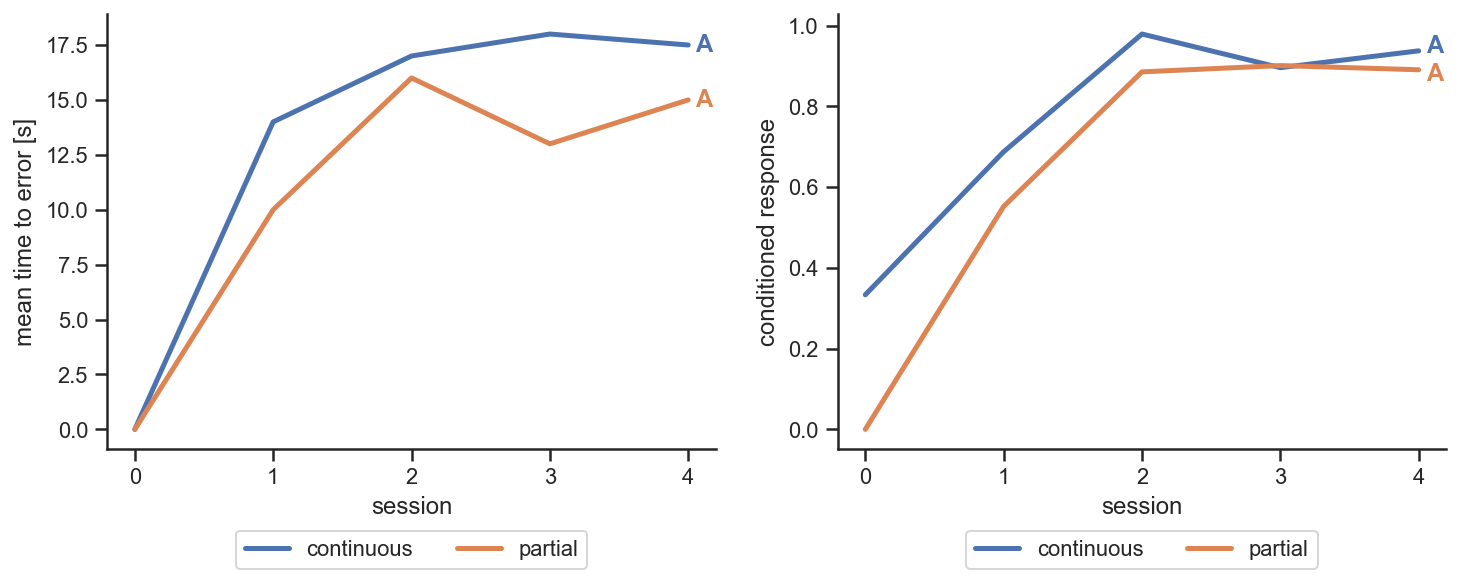

continuous:
  {
    train (repeat=10) {
      A+
    }
    extinction (repeat=16) {
      A-
    }
  }
partial:
  {
    train (repeat=5) {
      A+
      A-
    }
    extinction (repeat=16) {
      A-
    }
  }
correlation: -0.2053222475241106


,group,session,variable,value
0,continuous,0,A,1.00
1,continuous,1,A,0.95
2,continuous,2,A,0.75
3,continuous,3,A,0.25
4,continuous,4,A,0.05
5,partial,0,A,1.00
6,partial,1,A,0.95
7,partial,2,A,0.90
8,partial,3,A,0.70
9,partial,4,A,0.40


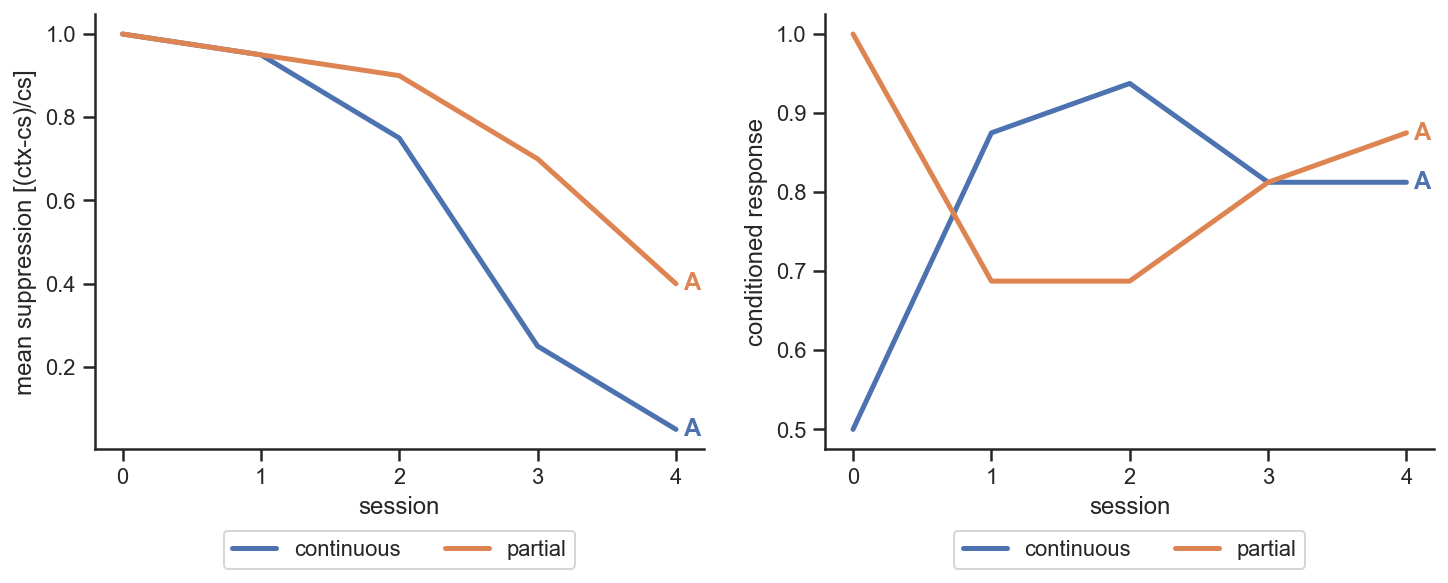

control:
  {
    train 1 (repeat=10) {
      A+
      B+
    }
    train 2 (repeat=10) {
      A+
      B+
      BX-
    }
    test (repeat=10) {
      A
    }
  }
external inhibition:
  {
    train 1 (repeat=10) {
      A+
      B+
    }
    train 2 (repeat=10) {
      A+
      B+
      BX-
    }
    test (repeat=10) {
      AC
    }
  }
conditioned inhibition:
  {
    train 1 (repeat=10) {
      A+
      B+
    }
    train 2 (repeat=10) {
      A+
      B+
      BX-
    }
    test (repeat=10) {
      AX
    }
  }
correlation: 0.8660254037844386


,group,variable,value
0,control,A,9.0
1,external inhibition,AC,5.5
2,conditioned inhibition,AX,2.0
,group,variable,value
0,control,A,0.900
1,external inhibition,AC,0.900
2,conditioned inhibition,AX,0.825


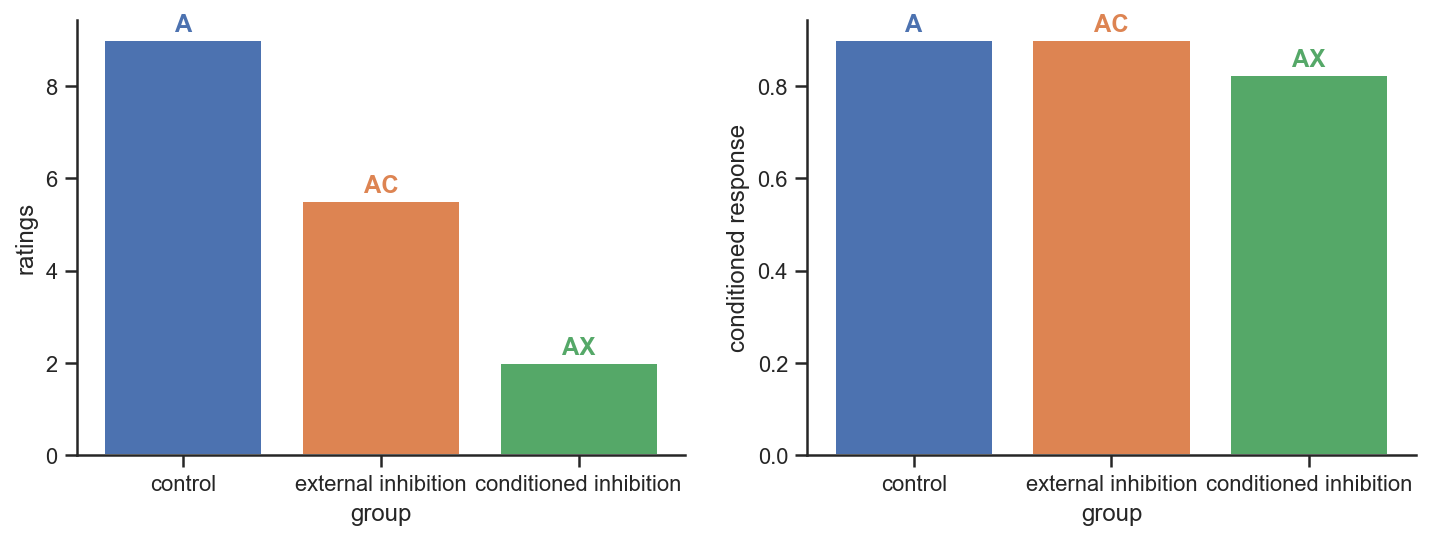

A:
  {
    train (repeat=500) {
      A+
    }
    (repeat=4) {
      test-A {
        A
      }
      test-AB {
        AB
      }
      test-ABC {
        ABC
      }
    }
  }
AB:
  {
    train (repeat=500) {
      AB+
    }
    (repeat=4) {
      test-A {
        A
      }
      test-AB {
        AB
      }
      test-ABC {
        ABC
      }
    }
  }
ABC:
  {
    train (repeat=500) {
      ABC+
    }
    (repeat=4) {
      test-A {
        A
      }
      test-AB {
        AB
      }
      test-ABC {
        ABC
      }
    }
  }
correlation: -0.06431566413843312


,group,variable,value
0,A,A,80
1,AB,A,20
2,ABC,A,20
3,A,AB,65
4,AB,AB,90
5,ABC,AB,50
6,A,ABC,55
7,AB,ABC,70
8,ABC,ABC,85
,group,variable,value


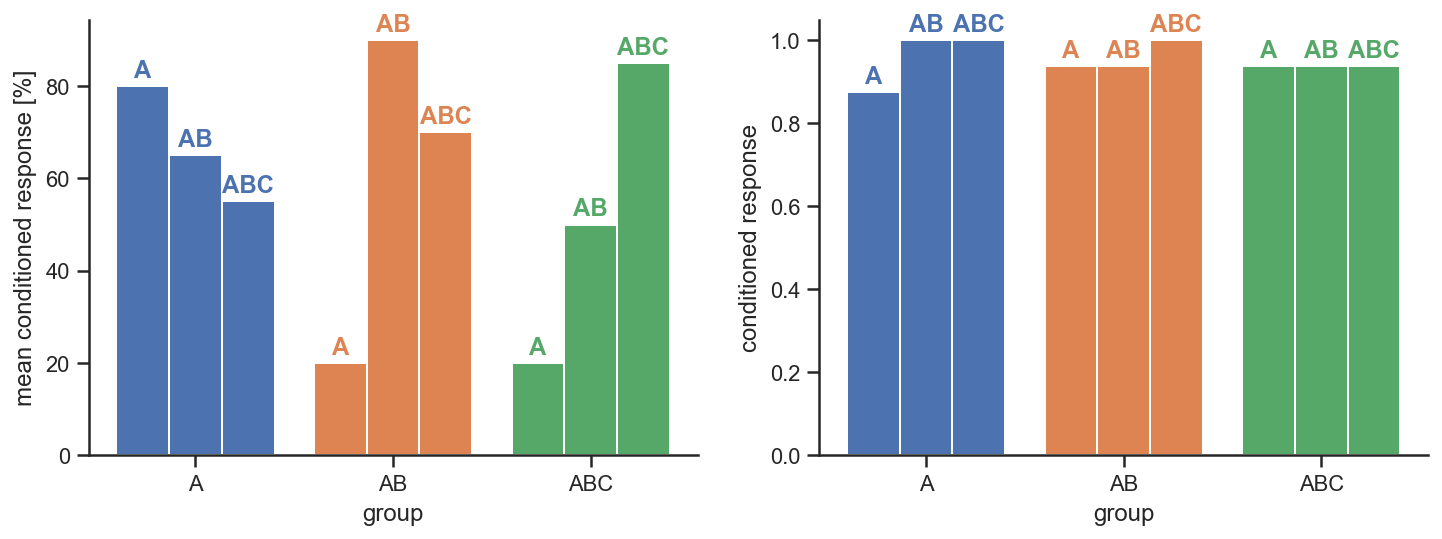

main:
  (repeat=250) {
    train-A {
      A+
    }
    train-B {
      B-
    }
  }
correlation: 0.4394324495085181


,group,session,variable,value
0,main,1,A,20
1,main,2,A,19
2,main,3,A,20
3,main,4,A,21
4,main,5,A,12
5,main,6,A,13
6,main,7,A,12
7,main,8,A,13
8,main,9,A,13
9,main,10,A,13


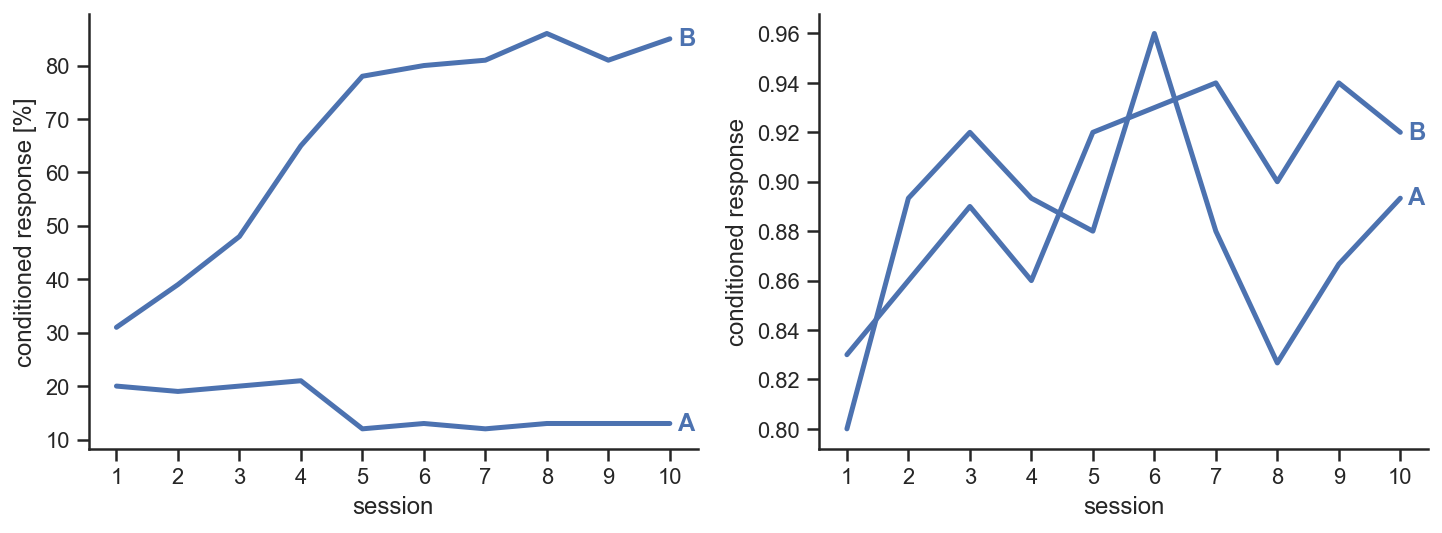

main:
  (repeat=480) {
    train-A {
      A-
    }
    train-B {
      B-
    }
    train-AB {
      AB+
    }
  }
correlation: 0.2567962409494146


,group,session,variable,value
0,main,1,A,11
1,main,2,A,41
2,main,3,A,61
3,main,4,A,54
4,main,5,A,63
...,...,...,...,...
67,main,20,AB,87
68,main,21,AB,84
69,main,22,AB,91
70,main,23,AB,86


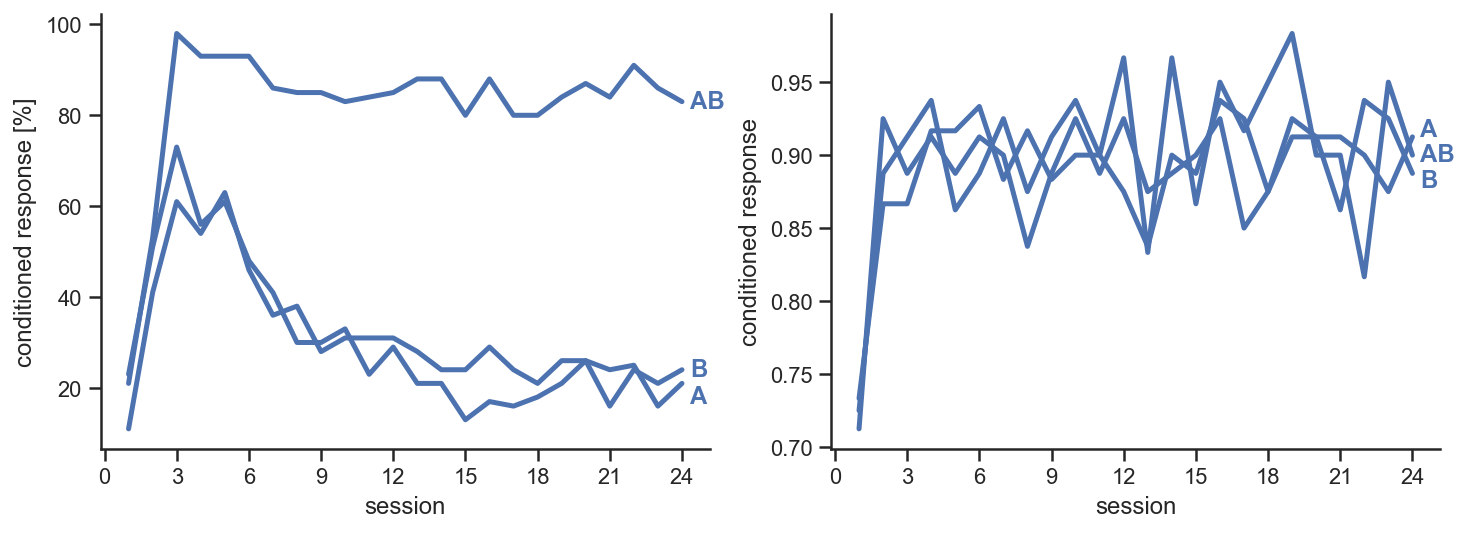

main:
  (repeat=480) {
    train-A {
      A+
    }
    train-B {
      B+
    }
    train-AB {
      AB-
    }
  }
correlation: 0.18620293081075148


,group,session,variable,value
0,main,1,A,38
1,main,2,A,51
2,main,3,A,78
3,main,4,A,81
4,main,5,A,89
...,...,...,...,...
67,main,20,AB,26
68,main,21,AB,28
69,main,22,AB,26
70,main,23,AB,31


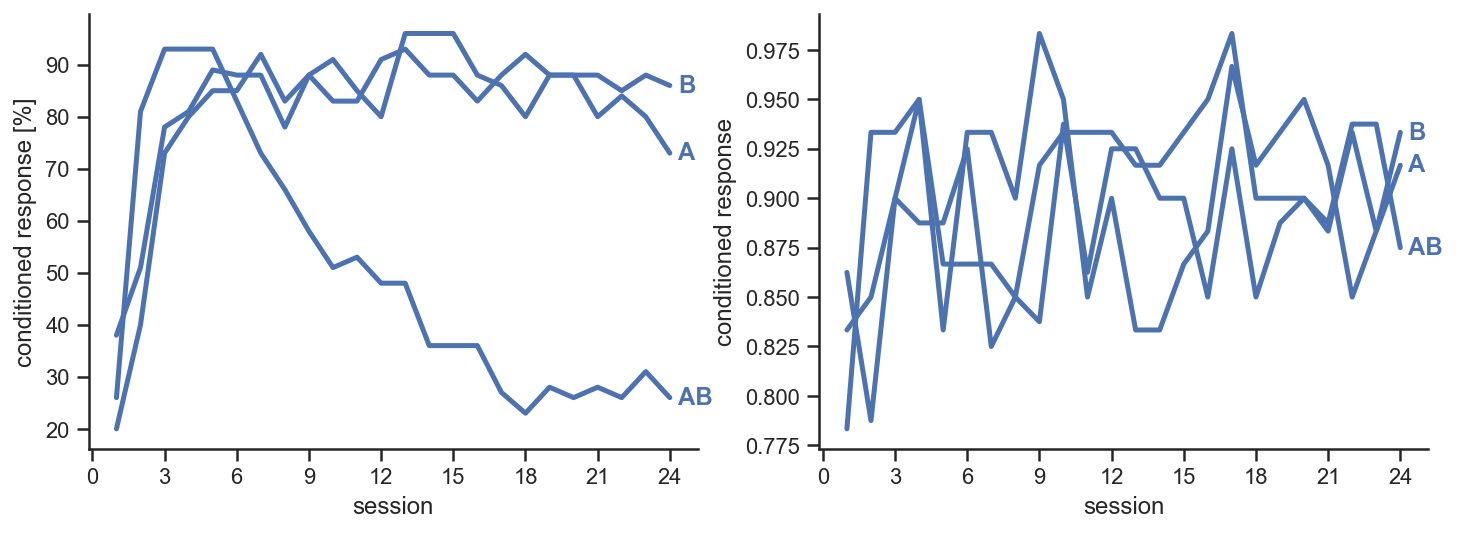

control:
  (repeat=70) {
    train-A {
      A+
    }
    train-B {
      B+
    }
    train-AB {
      AB-
    }
  }
common cue:
  (repeat=70) {
    train-AC {
      AC+
    }
    train-BC {
      BC+
    }
    train-ABC {
      ABC-
    }
  }
correlation: -0.0817546741295063


,group,session,variable,value
0,control,1,A,68
1,control,2,A,72
2,control,3,A,75
3,control,4,A,78
4,control,5,A,78
5,control,6,A,86
6,control,7,A,84
7,control,1,B,56
8,control,2,B,60
9,control,3,B,64


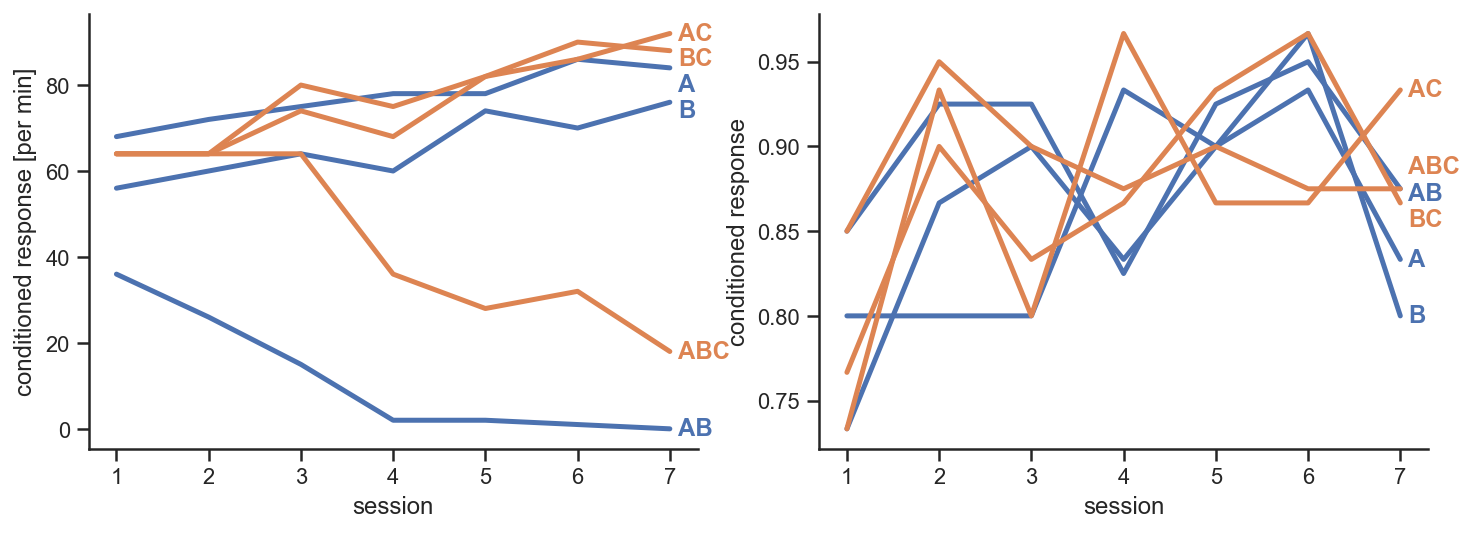

main:
  (repeat=50) {
    train-A {
      A+
    }
    train-BC {
      BC+
    }
    train-ABC {
      ABC-
    }
  }
correlation: 0.1025575073062279


,group,session,variable,value
0,main,1,A,80
1,main,2,A,142
2,main,3,A,158
3,main,4,A,164
4,main,5,A,168
5,main,6,A,160
6,main,7,A,164
7,main,8,A,160
8,main,9,A,166
9,main,10,A,169


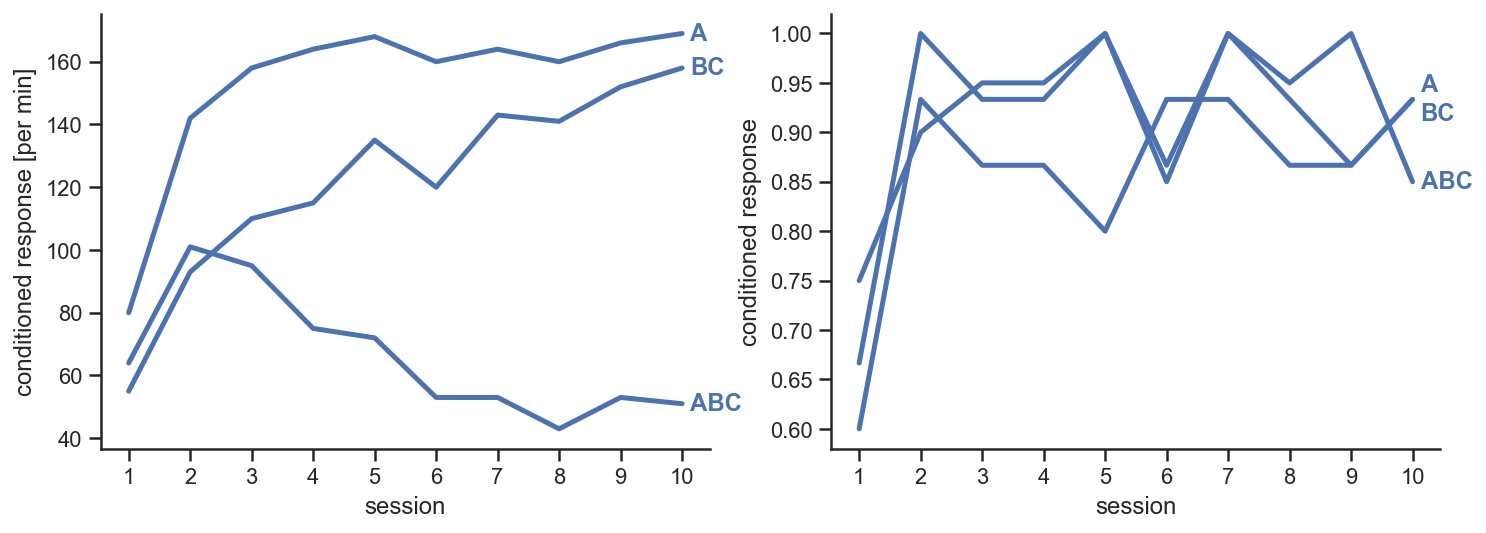

component:
  (repeat=50) {
    train-AC {
      AC+
    }
    train-AD {
      AD+
    }
    train-BC {
      BC-
    }
    train-BD {
      BD-
    }
  }
biconditional:
  (repeat=100) {
    train-AC {
      AC+
    }
    train-AD {
      AD-
    }
    train-BC {
      BC-
    }
    train-BD {
      BD+
    }
  }
correlation: 0.5145167500971332


,group,session,variable,value
0,component,1,+,34
1,component,2,+,70
2,component,3,+,90
3,component,4,+,91
4,component,5,+,91
5,biconditional,1,+,48
6,biconditional,2,+,65
7,biconditional,3,+,85
8,biconditional,4,+,88
9,biconditional,5,+,86


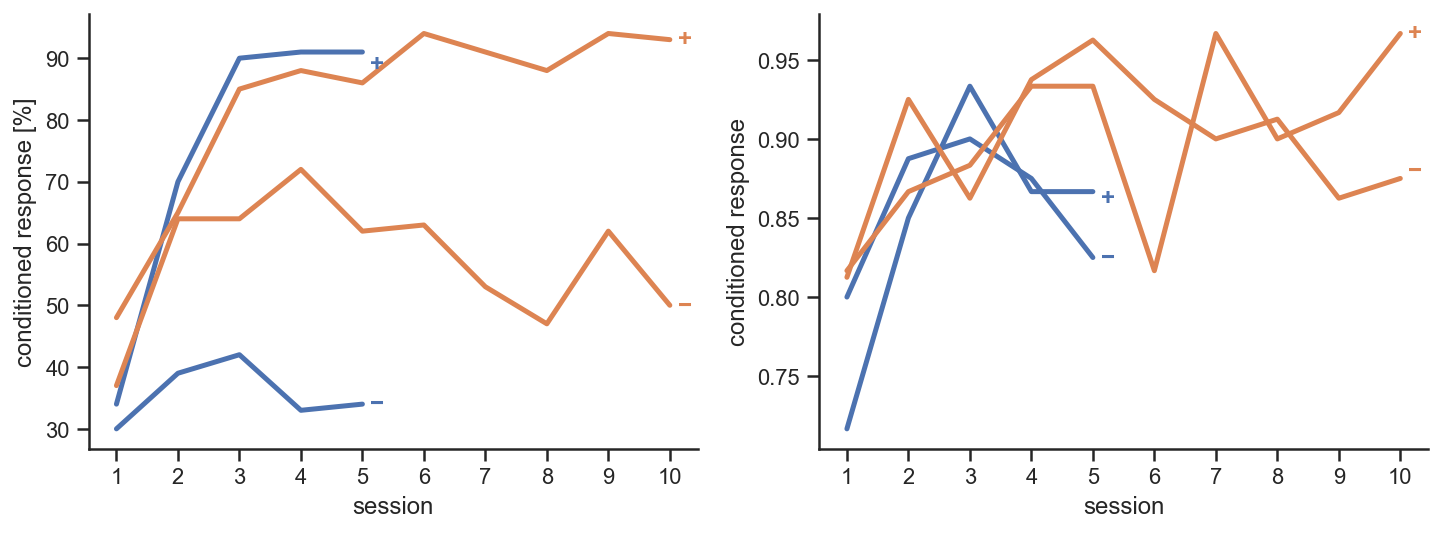

simultaneous:
  (repeat=180) {
    train-BA {
      BA+
    }
    train-A {
      A-
    }
  }
serial:
  (repeat=390) {
    train-BA {
      B -> A+
    }
    train-A {
      A-
    }
  }
correlation: -0.22634523056118375


,group,session,variable,value
0,simultaneous,1,BA,2
1,simultaneous,2,BA,4
2,simultaneous,3,BA,21
3,simultaneous,4,BA,56
4,simultaneous,5,BA,54
5,simultaneous,6,BA,65
6,serial,1,BA,0
7,serial,2,BA,4
8,serial,3,BA,0
9,serial,4,BA,21


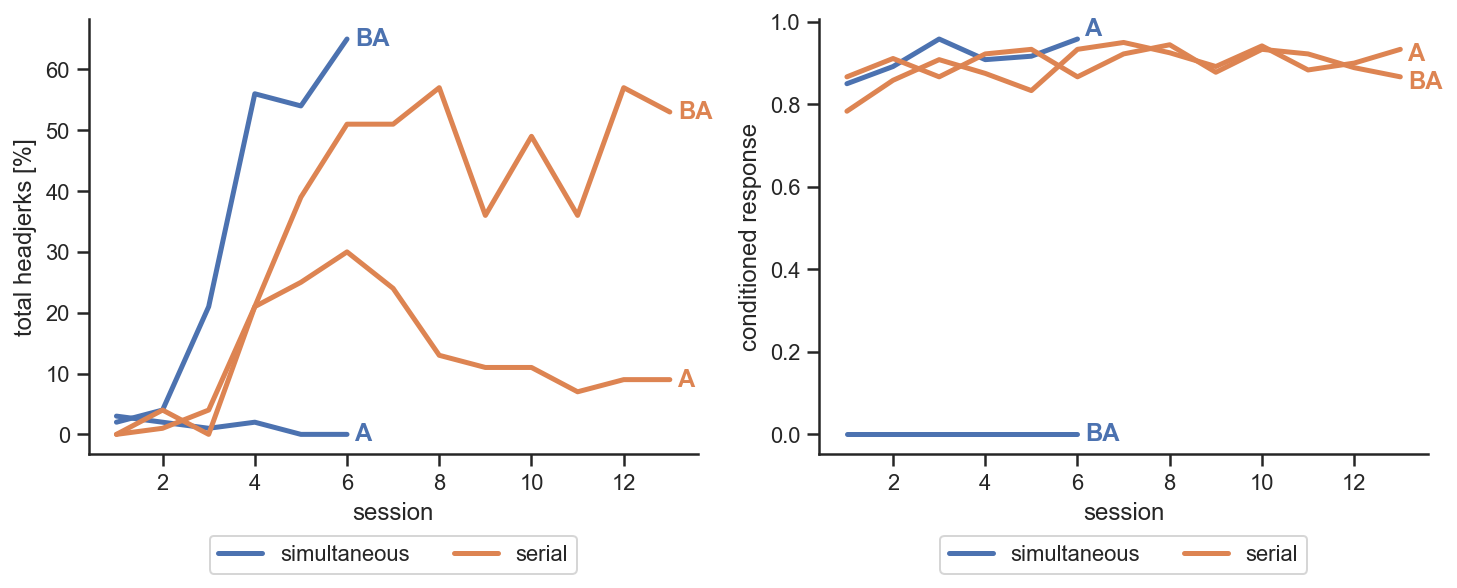

simultaneous:
  {
    acquisition (repeat=8) {
      A+
    }
    (repeat=12) {
      train-BA {
        BA-
      }
      train-A {
        A+
      }
    }
  }
serial:
  {
    acquisition (repeat=8) {
      A+
    }
    (repeat=48) {
      train-BA {
        B -> A
      }
      train-A {
        A+
      }
    }
  }
correlation: 0.17599304277693445


,group,session,variable,value
0,simultaneous,1,BA,0.34
1,simultaneous,2,BA,0.39
2,simultaneous,3,BA,0.49
3,serial,1,BA,0.15
4,serial,2,BA,0.19
5,serial,3,BA,0.23
6,serial,4,BA,0.18
7,serial,5,BA,0.22
8,serial,6,BA,0.29
9,serial,7,BA,0.22


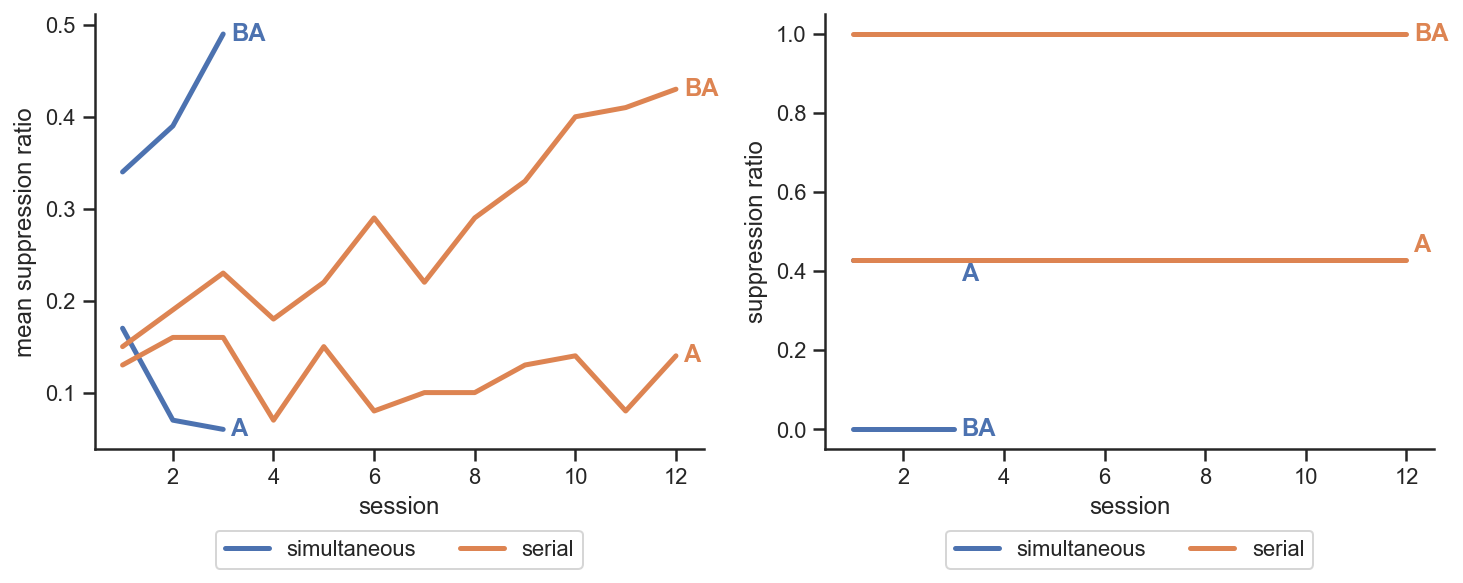

control:
  {
    train (repeat=40) {
      A+
      AX-
    }
    train (repeat=30) {
      -
      -
    }
    test-A {
      A
    }
    test-AX {
      AX
    }
  }
extinction:
  {
    train (repeat=40) {
      A+
      AX-
    }
    train (repeat=30) {
      A+
      AX+
    }
    test-A {
      A
    }
    test-AX {
      AX
    }
  }
correlation: nan


,group,variable,value
0,control,A,0.05
1,extinction,A,0.01
2,control,AX,0.23
3,extinction,AX,0.01
,group,variable,value
0,control,A,0.5
1,extinction,A,0.5
2,control,AX,0.5
3,extinction,AX,0.5


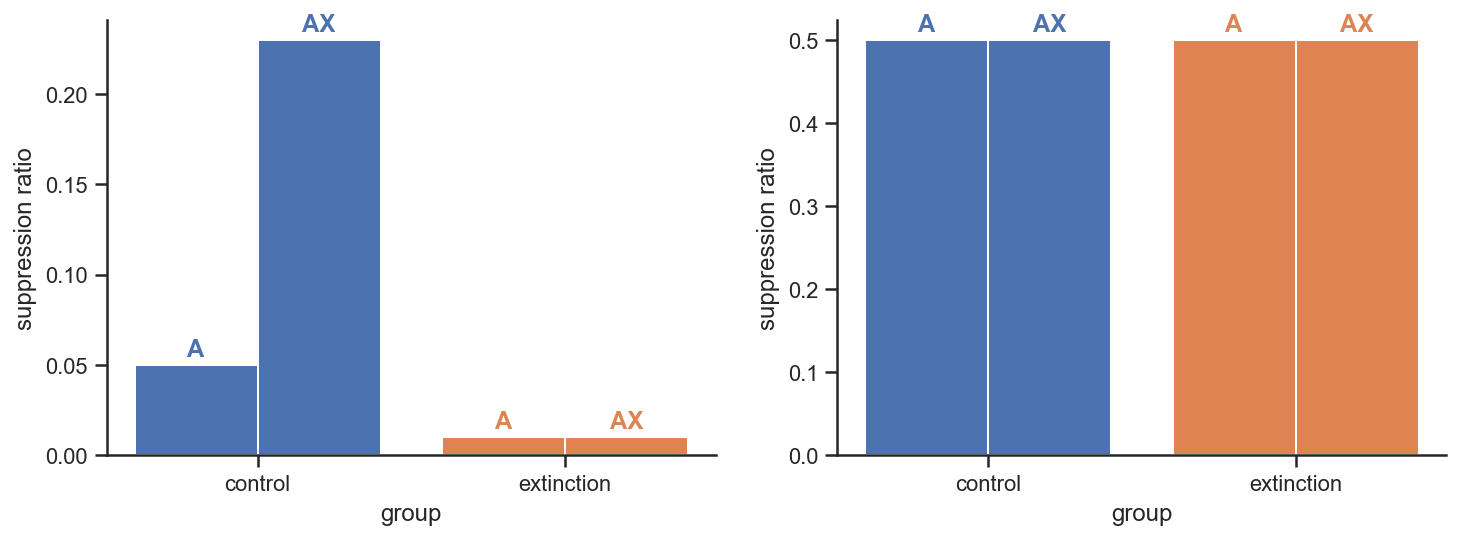

correlated:
  {
    train (repeat=200) {
      XA+
      XB-
    }
    test (repeat=10) {
      X
    }
  }
uncorrelated:
  {
    train (repeat=100) {
      XA+
      XA-
      XB+
      XB-
    }
    test (repeat=10) {
      X
    }
  }
correlation: -0.9999999999999999


,group,variable,value
0,correlated,X,20
1,uncorrelated,X,80
,group,variable,value
0,correlated,X,0.925
1,uncorrelated,X,0.850


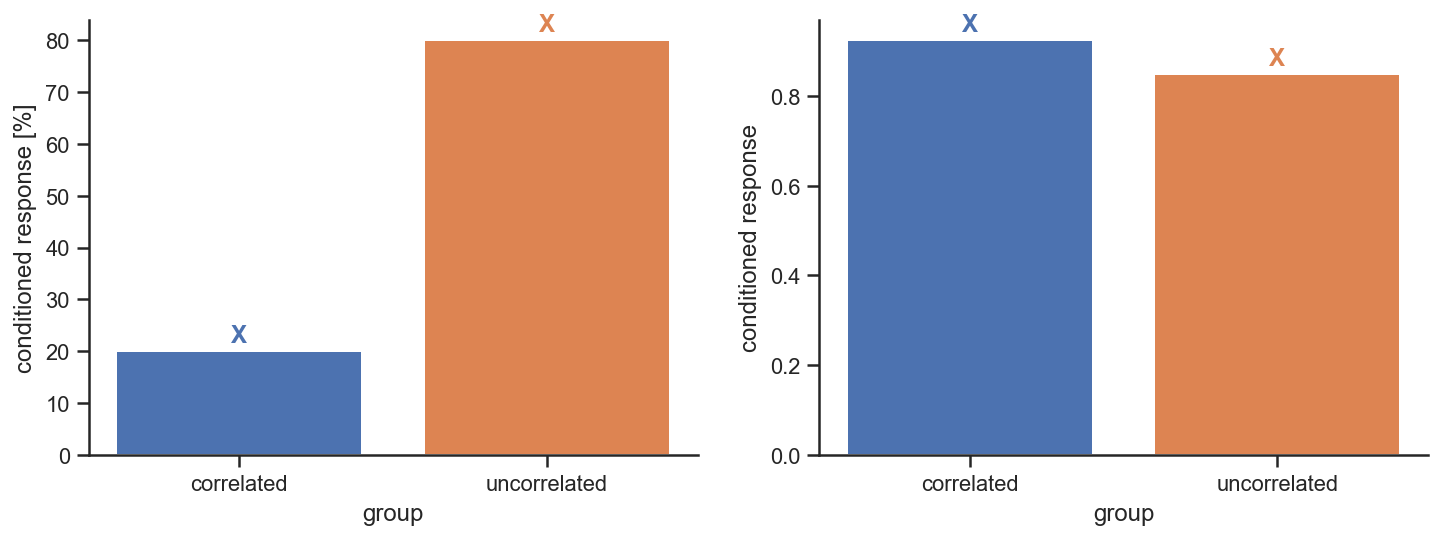

control:
  {
    train (repeat=20) {
      -
    }
    train (repeat=20) {
      A+
    }
    test {
      A
    }
  }
overshadowing:
  {
    train (repeat=20) {
      C+
    }
    train (repeat=20) {
      AB+
    }
    test {
      A
    }
  }
forward blocking:
  {
    train (repeat=20) {
      B+
    }
    train (repeat=20) {
      AB+
    }
    test {
      A
    }
  }
correlation: -0.03266276672320063


,group,variable,value
0,control,A,65
1,overshadowing,A,40
2,forward blocking,A,12
,group,variable,value
0,control,A,1.00
1,overshadowing,A,0.75
2,forward blocking,A,1.00


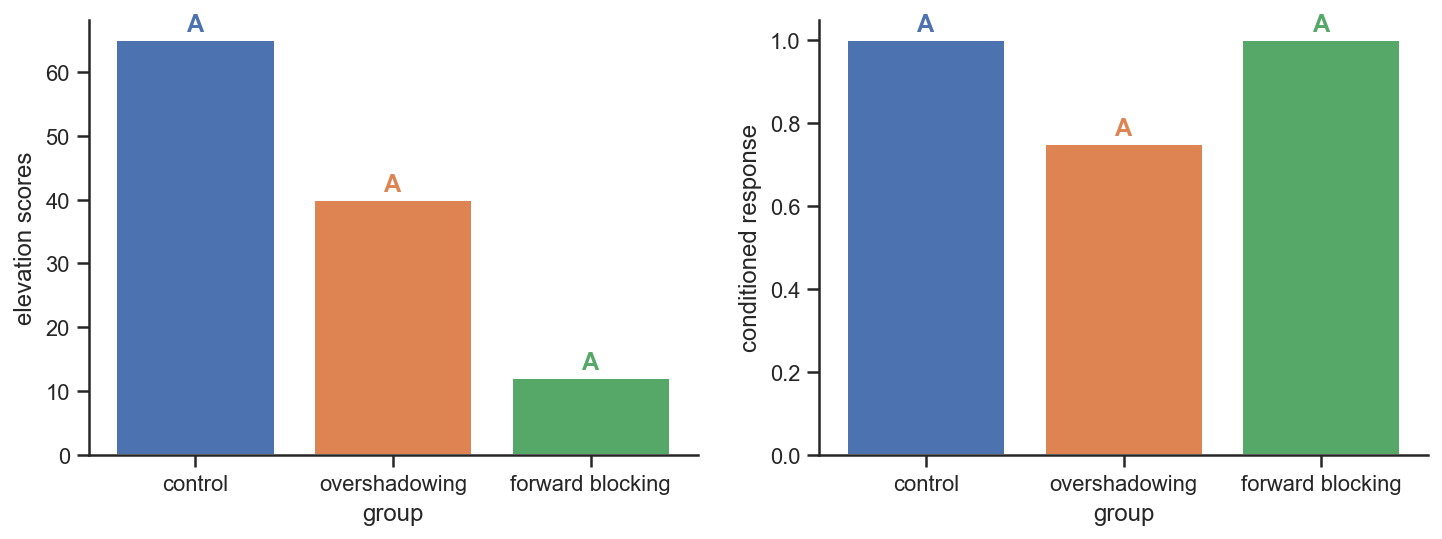

weak/weak:
  {
    train (repeat=40) {
      B+
    }
    train (repeat=280) {
      AB+
    }
    test {
      A
    }
  }
weak/strong:
  {
    train (repeat=40) {
      B+
    }
    train (repeat=280) {
      AB#
    }
    test {
      A
    }
  }
strong/strong:
  {
    train (repeat=40) {
      B#
    }
    train (repeat=280) {
      AB#
    }
    test {
      A
    }
  }
strong/weak:
  {
    train (repeat=40) {
      B#
    }
    train (repeat=280) {
      AB+
    }
    test {
      A
    }
  }
correlation: nan


,group,variable,value
0,weak/weak,A,0.47
1,weak/strong,A,0.32
2,strong/strong,A,0.44
3,strong/weak,A,0.30
,group,variable,value
0,weak/weak,A,0.5
1,weak/strong,A,0.5
2,strong/strong,A,0.5
3,strong/weak,A,0.5


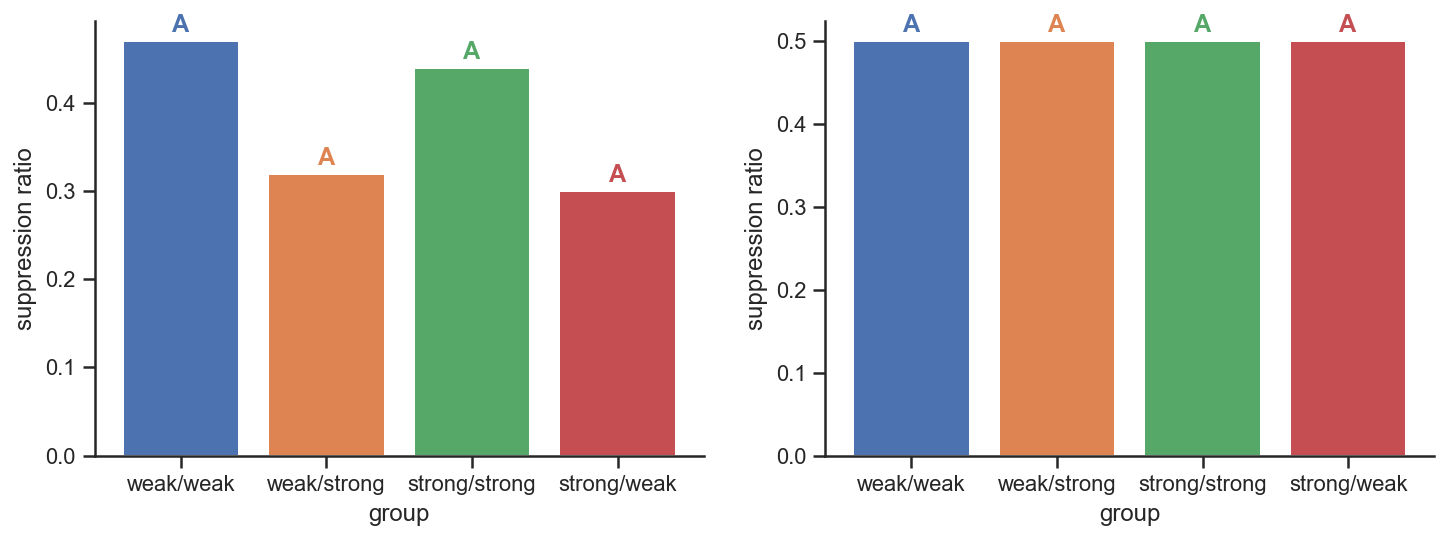

control:
  {
    train (repeat=20) {
      AB+
    }
    train (repeat=20) {
      C+
    }
    test {
      A
    }
  }
backward blocking:
  {
    train (repeat=20) {
      AB+
    }
    train (repeat=20) {
      B+
    }
    test {
      A
    }
  }
correlation: 0.9999999999999999


,group,variable,value
0,control,A,1.55
1,backward blocking,A,1.05
,group,variable,value
0,control,A,0.75
1,backward blocking,A,0.50


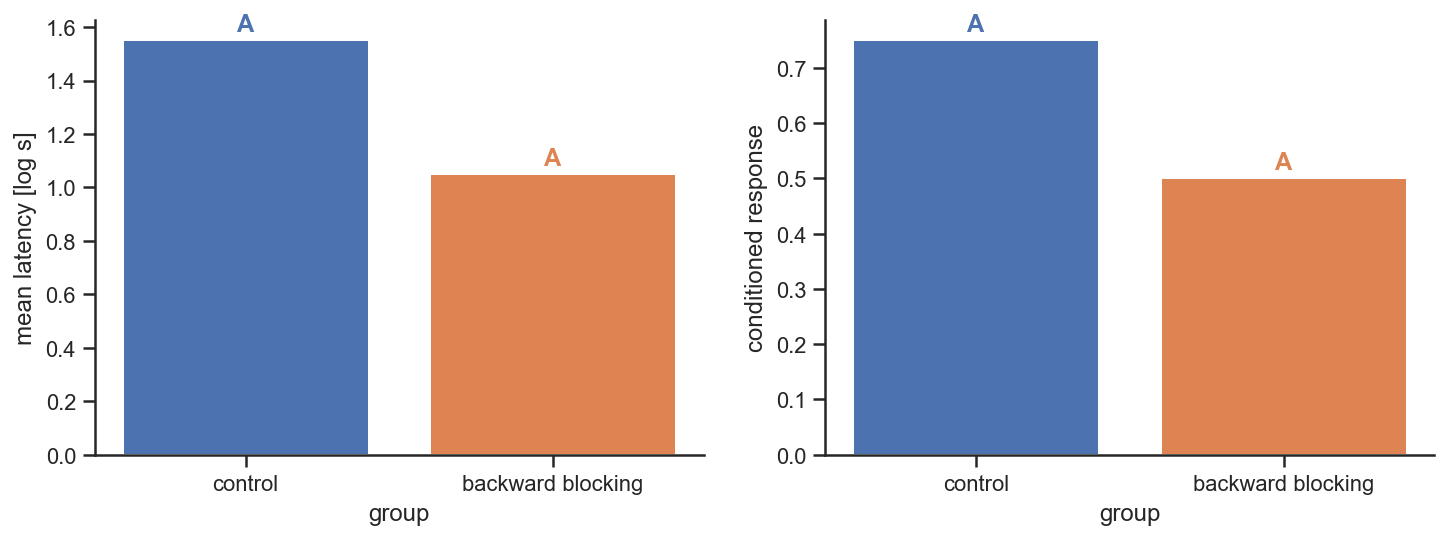

control 1:
  {
    train (repeat=16) {
      A+
    }
    train (repeat=16) {
      B+
    }
    test (repeat=2) {
      A
    }
  }
control 2:
  {
    train (repeat=16) {
      A+
    }
    train (repeat=16) {
      B+
    }
    train (repeat=2) {
      A+
    }
    test (repeat=2) {
      A
    }
  }
overexpectation:
  {
    train (repeat=16) {
      A+
    }
    train (repeat=16) {
      B+
    }
    train (repeat=2) {
      AB+
    }
    test (repeat=2) {
      A
    }
  }
correlation: nan


,group,variable,value
0,control 1,A,0.14
1,control 2,A,0.11
2,overexpectation,A,0.44
,group,variable,value
0,control 1,A,0.5
1,control 2,A,0.5
2,overexpectation,A,0.5


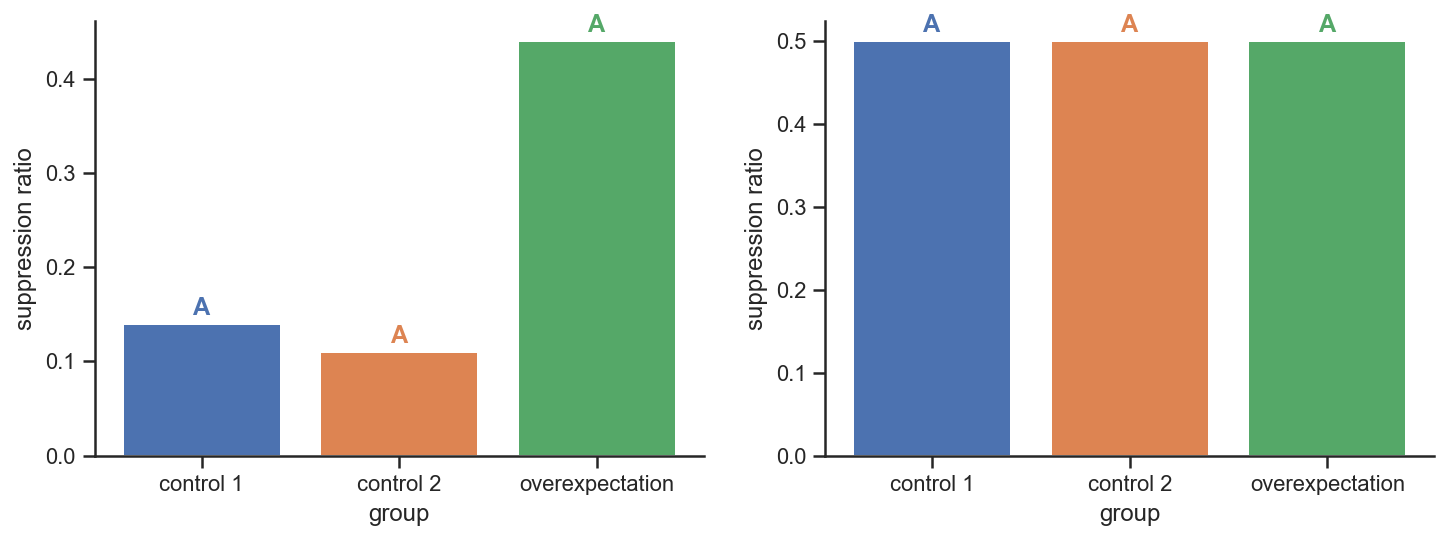

forward blocking:
  {
    train (repeat=40) {
      B+
    }
    train (repeat=2) {
      AB+
    }
    test (repeat=3) {
      A
    }
  }
overshadowing:
  {
    train (repeat=40) {
      -
      +
    }
    train (repeat=2) {
      AB+
    }
    test (repeat=3) {
      A
    }
  }
superconditioning:
  {
    train (repeat=40) {
      B-
      +
    }
    train (repeat=2) {
      AB+
    }
    test (repeat=3) {
      A
    }
  }
correlation: nan


,group,variable,value
0,forward blocking,A,0.31
1,overshadowing,A,0.25
2,superconditioning,A,0.16
,group,variable,value
0,forward blocking,A,0.5
1,overshadowing,A,0.5
2,superconditioning,A,0.5


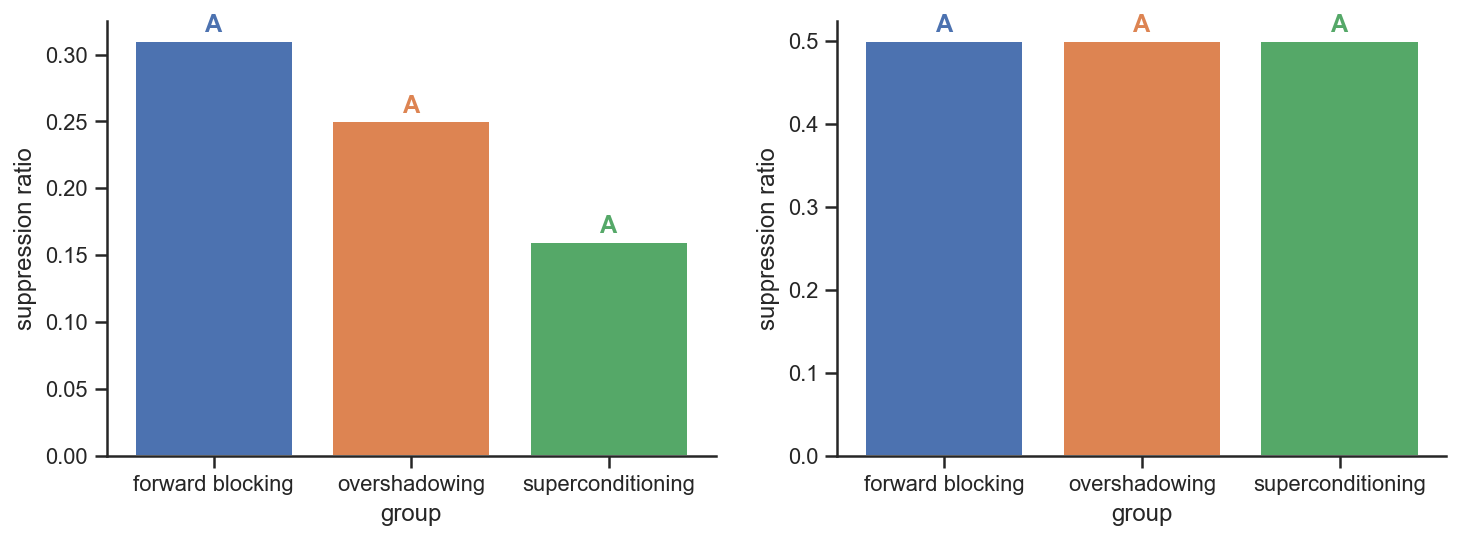

same ctx, no preexpose:
  {
    preexpose (repeat=20) {
      B-
    }
    test (repeat=10) {
      A+
    }
  }
same ctx, preexpose:
  {
    preexpose (repeat=20) {
      A-
    }
    test (repeat=10) {
      A+
    }
  }
different ctx, no preexpose:
  {
    preexpose (repeat=20) {
      B-
    }
    test (repeat=10) {
      A+
    }
  }
different ctx, preexpose:
  {
    preexpose (repeat=20) {
      A-
    }
    test (repeat=10) {
      A+
    }
  }
correlation: -0.0956017485645791


,group,variable,value
0,"same ctx, no preexpose",A,0.67
1,"same ctx, preexpose",A,0.09
2,"different ctx, no preexpose",A,0.31
3,"different ctx, preexpose",A,0.72
,group,variable,value
0,"same ctx, no preexpose",A,0.533333
1,"same ctx, preexpose",A,0.666667
2,"different ctx, no preexpose",A,0.566667
3,"different ctx, preexpose",A,0.700000


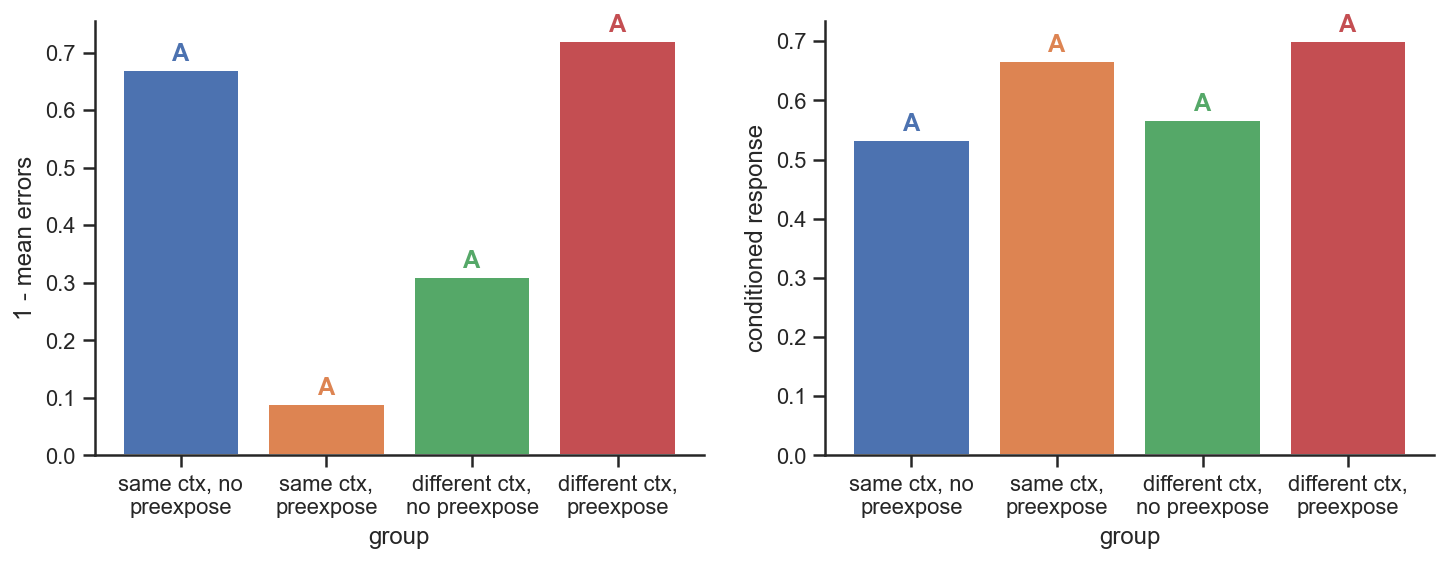

no preexpose:
  {
    test (repeat=40) {
      A+
    }
  }
preexpose:
  {
    preexpose (repeat=70) {
      +
    }
    test (repeat=40) {
      A+
    }
  }
correlation: nan


,group,variable,value
0,no preexpose,A,0.12
1,preexpose,A,0.23
,group,variable,value
0,no preexpose,A,0.428571
1,preexpose,A,0.428571


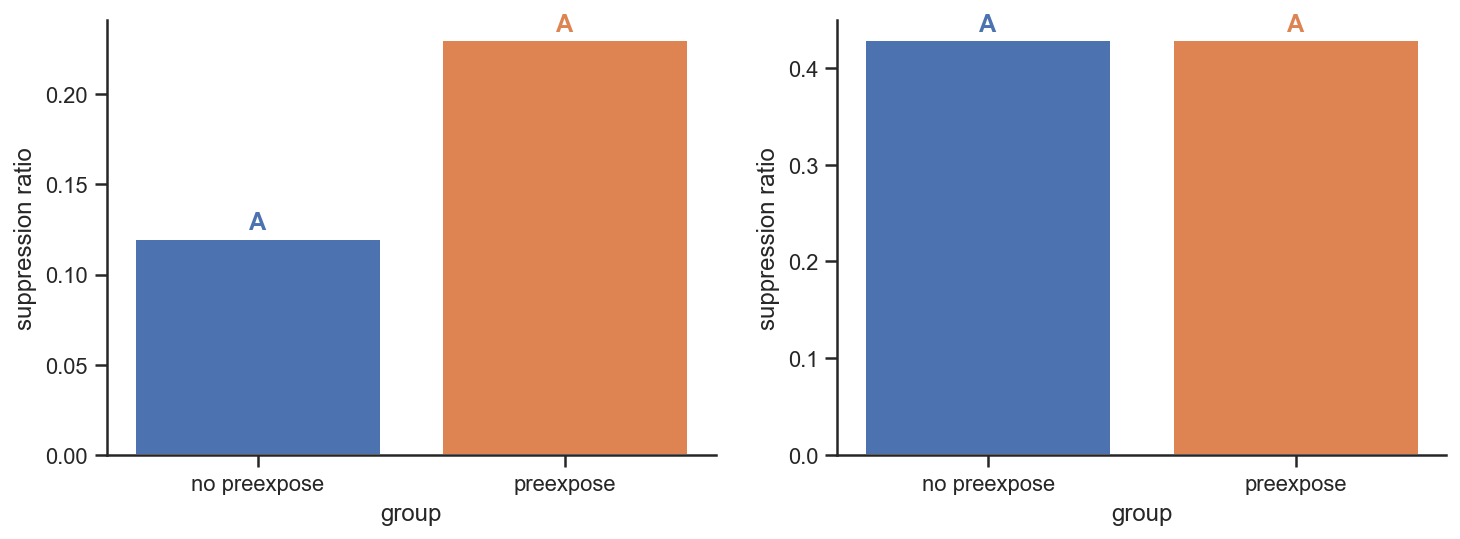

control few:
  {
    acquisition (repeat=10) {
      -
    }
    extinction (repeat=15) {
      -
    }
    reacquisition (repeat=8) {
      A+
    }
  }
extinction few:
  {
    acquisition (repeat=10) {
      A+
    }
    extinction (repeat=15) {
      A-
    }
    reacquisition (repeat=8) {
      A+
    }
  }
control many:
  {
    acquisition (repeat=10) {
      -
    }
    extinction (repeat=100) {
      -
    }
    reacquisition (repeat=12) {
      A+
    }
  }
extinction many:
  {
    acquisition (repeat=10) {
      A+
    }
    extinction (repeat=100) {
      A-
    }
    reacquisition (repeat=12) {
      A+
    }
  }
correlation: 0.3038435075202462


,group,session,variable,value
0,control few,1,A,1.4
1,control few,2,A,3.4
2,control few,3,A,2.6
3,control few,4,A,4.6
4,control few,5,A,3.8
5,control few,6,A,6.2
6,control few,7,A,5.8
7,control few,8,A,7.6
8,extinction few,1,A,3.2
9,extinction few,2,A,6.0


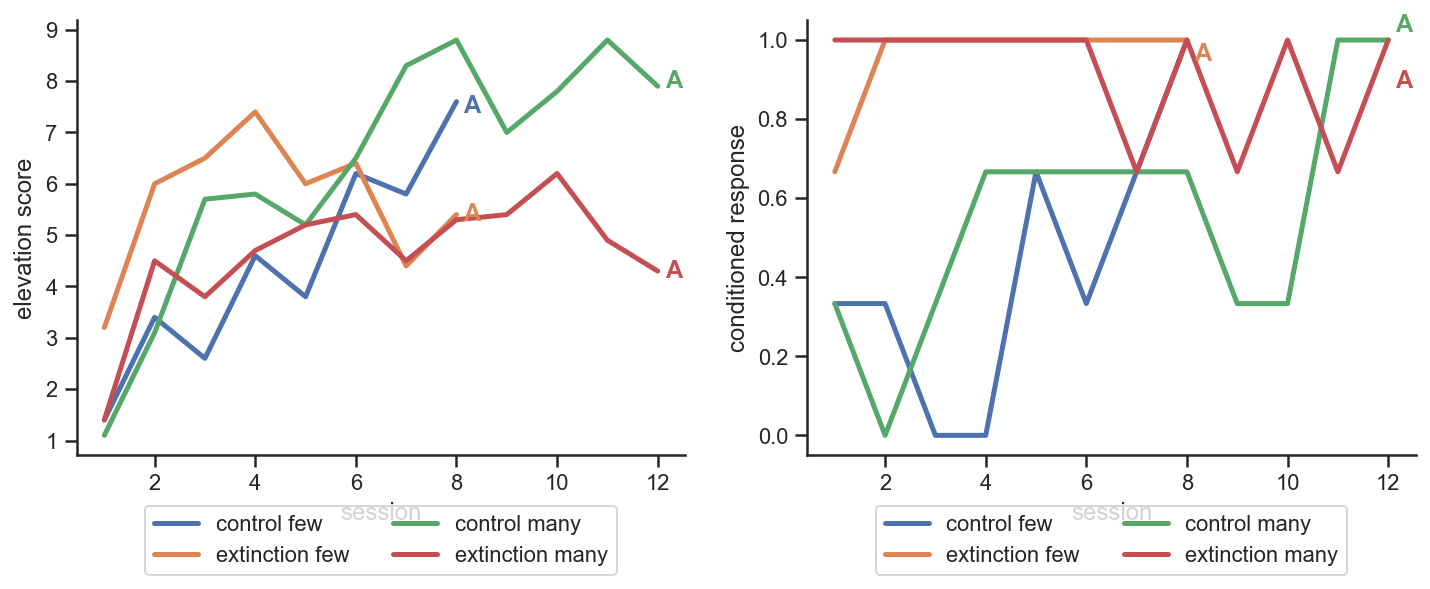

control:
  {
    train (repeat=40) {
      -
    }
    train (repeat=10) {
      A+
    }
    test (repeat=3) {
      A
    }
  }
latent inhibition:
  {
    train (repeat=40) {
      A-
    }
    train (repeat=10) {
      A+
    }
    test (repeat=3) {
      A
    }
  }
control recovery:
  {
    train (repeat=40) {
      -
    }
    train (repeat=10) {
      A+
    }
    train (repeat=40) {
      -
    }
    test (repeat=3) {
      A
    }
  }
latent inhibition recovery:
  {
    train (repeat=40) {
      A-
    }
    train (repeat=10) {
      A+
    }
    train (repeat=40) {
      -
    }
    test (repeat=3) {
      A
    }
  }
correlation: 0.0


,group,variable,value
0,control,A,2.2
1,latent inhibition,A,1.6
2,control recovery,A,1.9
3,latent inhibition recovery,A,1.9
,group,variable,value
0,control,A,0.916667
1,latent inhibition,A,0.916667
2,control recovery,A,0.833333
3,latent inhibition recovery,A,1.000000


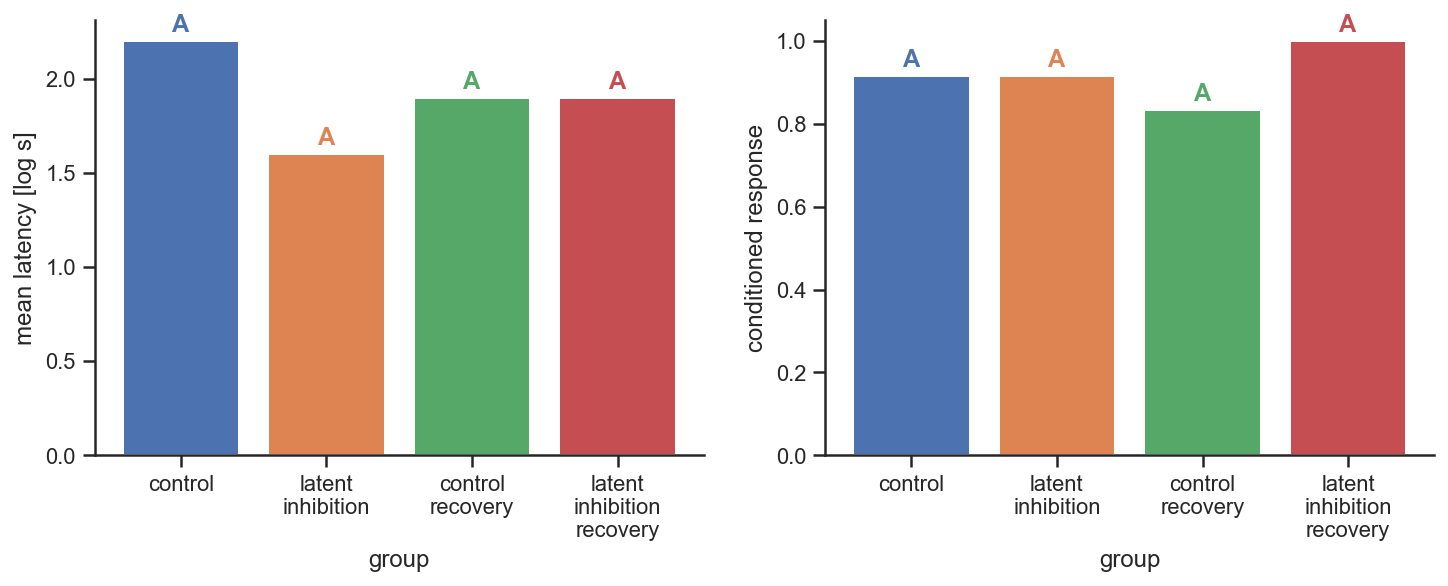

control:
  {
    train (repeat=10) {
      A+
    }
    train (repeat=10) {
      -
    }
    test {
      A
    }
  }
overshadowing:
  {
    train (repeat=10) {
      AB+
    }
    train (repeat=10) {
      -
    }
    test {
      A
    }
  }
overshadowing recovery:
  {
    train (repeat=10) {
      AB+
    }
    train (repeat=10) {
      B-
    }
    test {
      A
    }
  }
correlation: -0.832239719563824


,group,variable,value
0,control,A,1.95
1,overshadowing,A,1.05
2,overshadowing recovery,A,1.55
,group,variable,value
0,control,A,0.75
1,overshadowing,A,1.00
2,overshadowing recovery,A,1.00


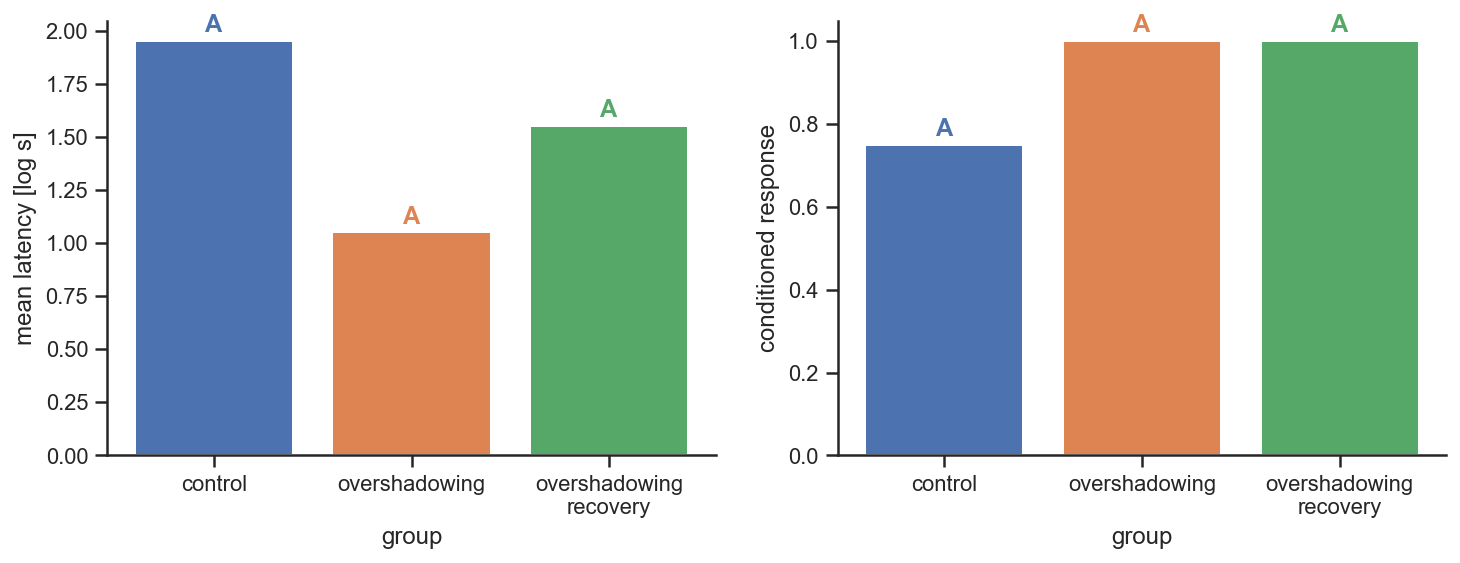

main:
  {
    acquisition (repeat=10) {
      A+
    }
    extinction (repeat=30) {
      A-
    }
    test-1 (repeat=3) {
      B -> A+
    }
    test-2 (repeat=3) {
      B -> A+
    }
  }
correlation: 0.685976154612025


,group,variable,value
0,main,extinction,0.50
1,main,test 1,0.85
2,main,test 2,0.78
,group,variable,value
0,main,extinction,0.883333
1,main,test 1,1.000000
2,main,test 2,0.888889


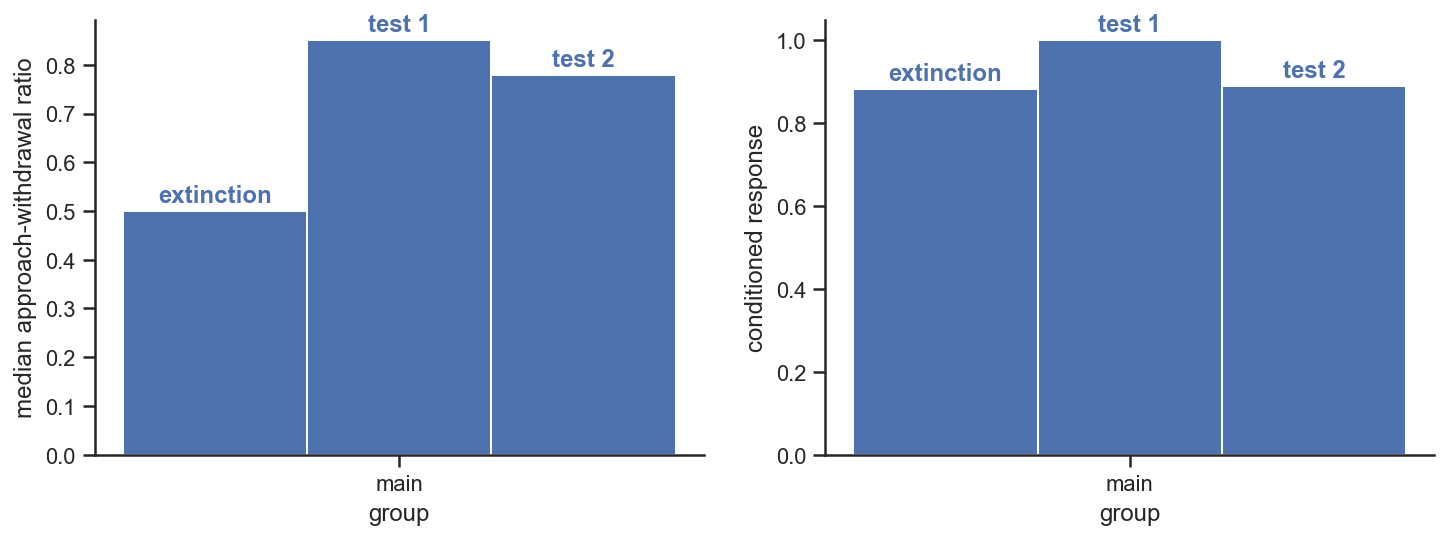

no delay:
  {
    acquisition (repeat=12) {
      A+
    }
    extinction (repeat=4) {
      A-
    }
    test (repeat=4) {
      A
    }
  }
delay:
  {
    acquisition (repeat=12) {
      A+
    }
    delay (repeat=12) {
      -
    }
    extinction (repeat=4) {
      A-
    }
    test (repeat=4) {
      A
    }
  }
correlation: -0.14394545389633115


,group,session,variable,value
0,no delay,1,A,5.0
1,no delay,2,A,8.0
2,no delay,3,A,10.0
3,no delay,4,A,11.5
4,no delay,5,A,13.0
5,no delay,6,A,13.2
6,no delay,7,A,14.5
7,no delay,8,A,14.0
8,no delay,9,A,14.2
9,no delay,10,A,14.2


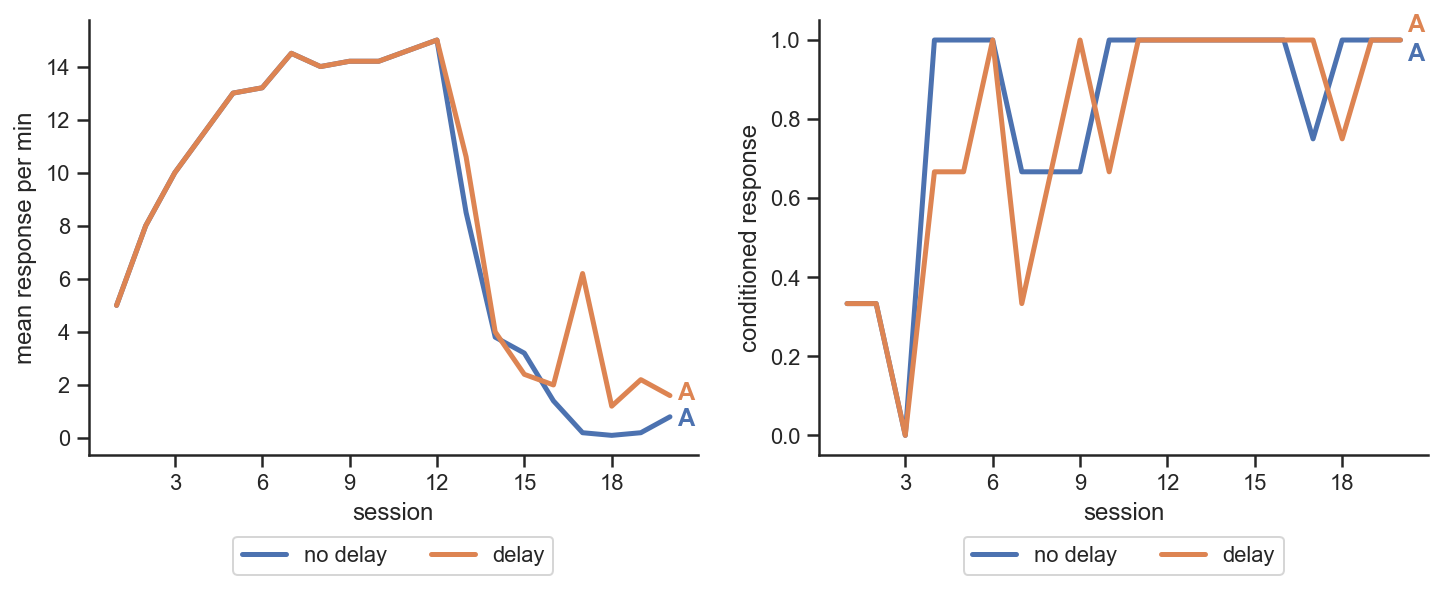

same context:
  {
    acquisition (repeat=15) {
      A+
    }
    extinction (repeat=20) {
      A-
    }
    test (repeat=10) {
      A
    }
  }
novel context:
  {
    acquisition (repeat=15) {
      A+
    }
    extinction (repeat=20) {
      A-
    }
    test (repeat=10) {
      A
    }
  }
correlation: -1.0


,group,variable,value
0,same context,A,27
1,novel context,A,55
,group,variable,value
0,same context,A,0.950
1,novel context,A,0.925


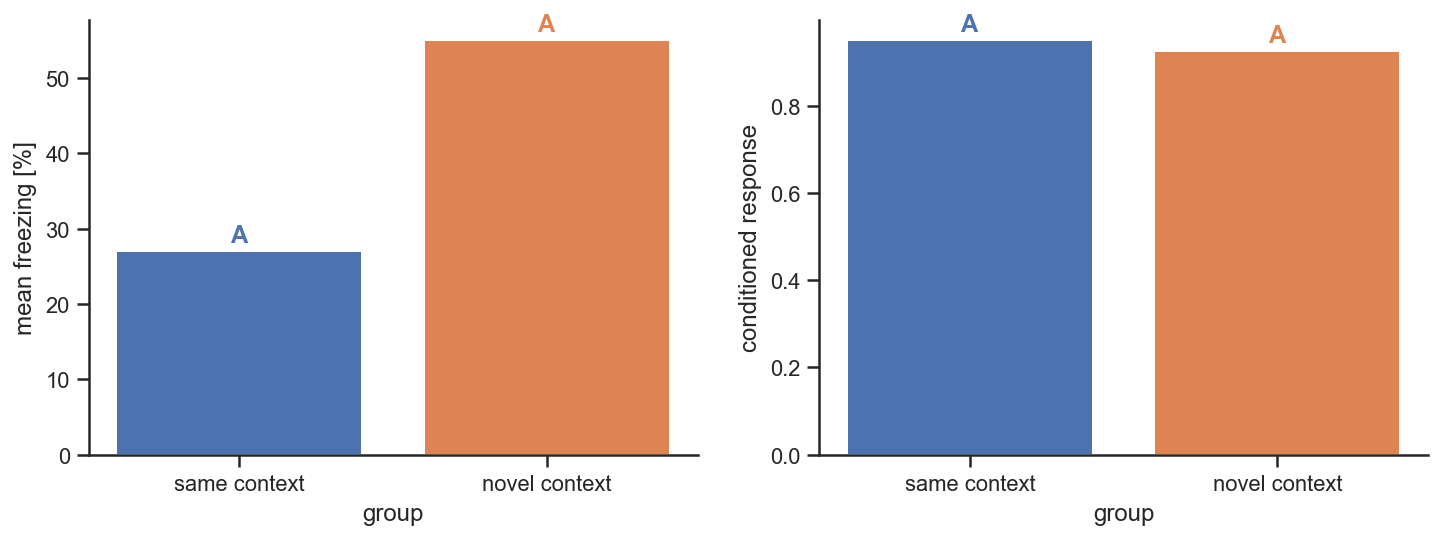

no US:
  {
    acquisition (repeat=100) {
      A+
    }
    extinction (repeat=35) {
      A-
    }
    reinstatement (repeat=40) {
      -
    }
    test-1 (repeat=10) {
      A
    }
    test-2 (repeat=10) {
      A
    }
  }
US:
  {
    acquisition (repeat=100) {
      A+
    }
    extinction (repeat=35) {
      A-
    }
    reinstatement (repeat=40) {
      +
    }
    test-1 (repeat=10) {
      A
    }
    test-2 (repeat=10) {
      A
    }
  }
correlation: nan


,group,variable,value
0,no US,extinction,0.35
1,US,extinction,0.40
2,no US,test 1,0.40
3,US,test 1,0.21
4,no US,test 2,0.40
5,US,test 2,0.36
,group,variable,value
0,no US,extinction,0.5
1,US,extinction,0.5
2,no US,test 1,0.5


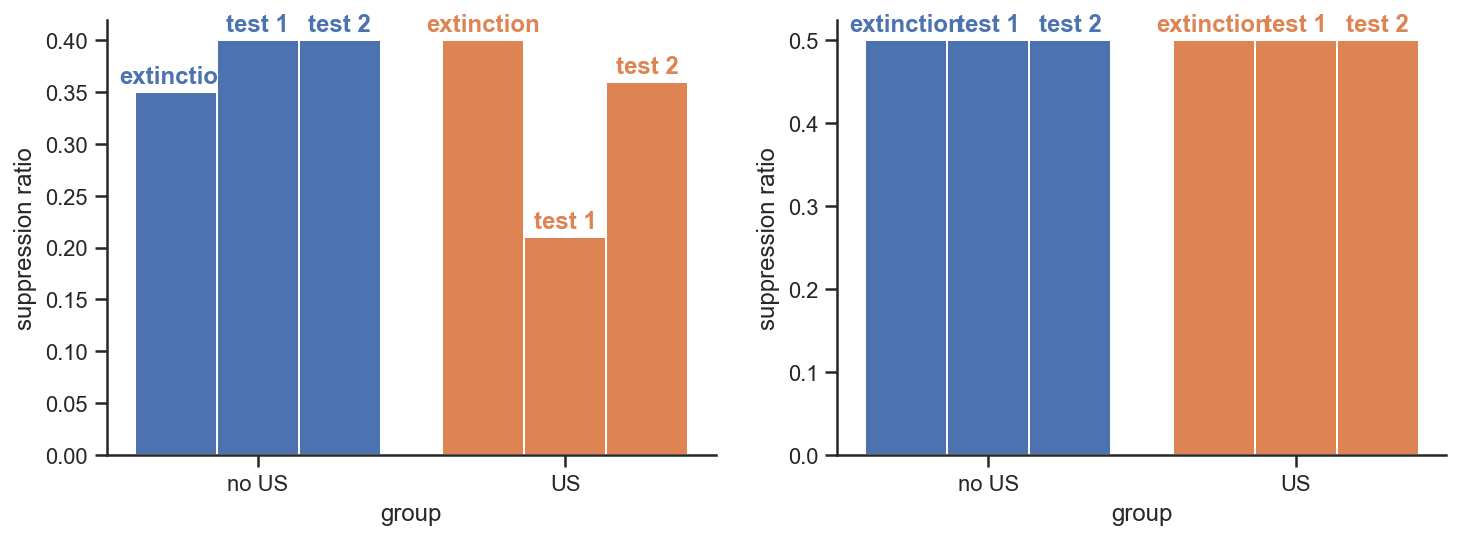

control:
  {
    train (repeat=100) {
      -
    }
    train (repeat=20) {
      A+
    }
    test {
      B
    }
  }
sensory preconditioning:
  {
    train (repeat=100) {
      AB-
    }
    train (repeat=20) {
      A+
    }
    test {
      B
    }
  }
correlation: nan


,group,variable,value
0,control,B,0.5
1,sensory preconditioning,B,9.5
,group,variable,value
0,control,B,1.0
1,sensory preconditioning,B,1.0


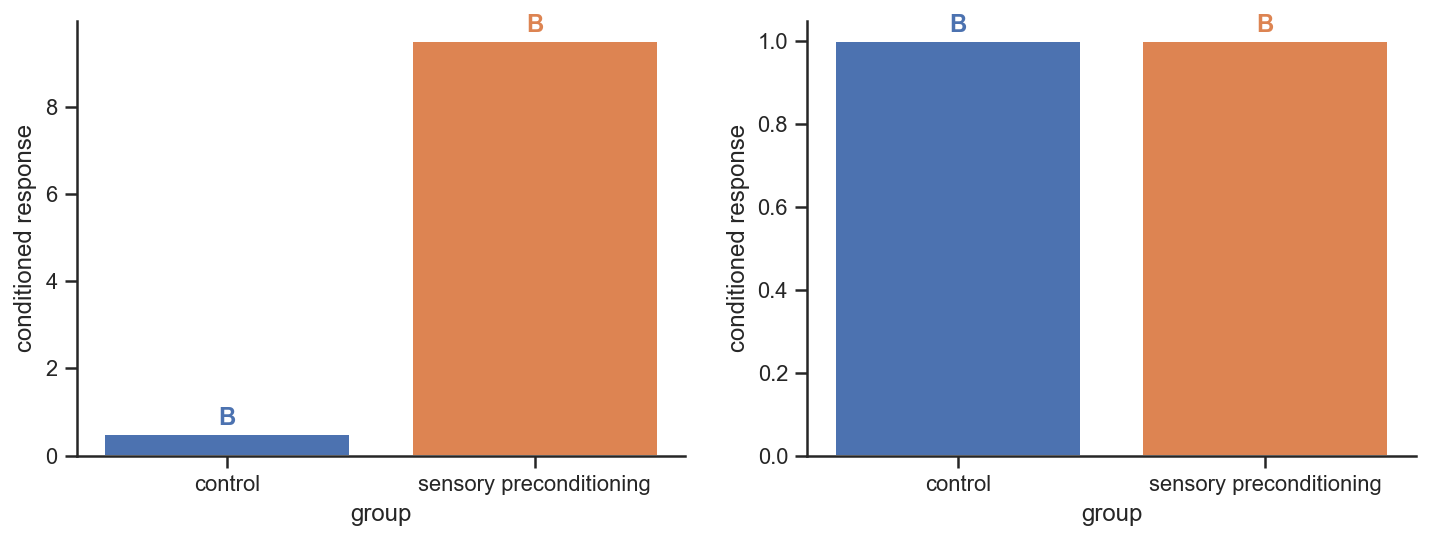

control:
  {
    train (repeat=170) {
      AB+
    }
    test (repeat=4) {
      B
    }
  }
interspersed few:
  {
    train (repeat=85) {
      A+
    }
    train {
      AB-
    }
    train (repeat=85) {
      A+
    }
    test (repeat=4) {
      B
    }
  }
sequential few:
  {
    train (repeat=170) {
      A+
    }
    train {
      AB-
    }
    test (repeat=4) {
      B
    }
  }
interspersed many:
  {
    train (repeat=85) {
      (repeat=2) {
        A+
      }
      {
        AB-
      }
    }
    test (repeat=4) {
      B
    }
  }
sequential many:
  {
    train (repeat=170) {
      A+
    }
    train (repeat=85) {
      AB-
    }
    test (repeat=4) {
      B
    }
  }
correlation: -0.08953819982122661


,group,variable,value
0,control,B,1.00
1,interspersed few,B,1.90
2,sequential few,B,1.73
3,interspersed many,B,0.93
4,sequential many,B,0.80
,group,variable,value
0,control,B,0.9375
1,interspersed few,B,1.0000
2,sequential few,B,0.7500
3,interspersed many,B,0.9375


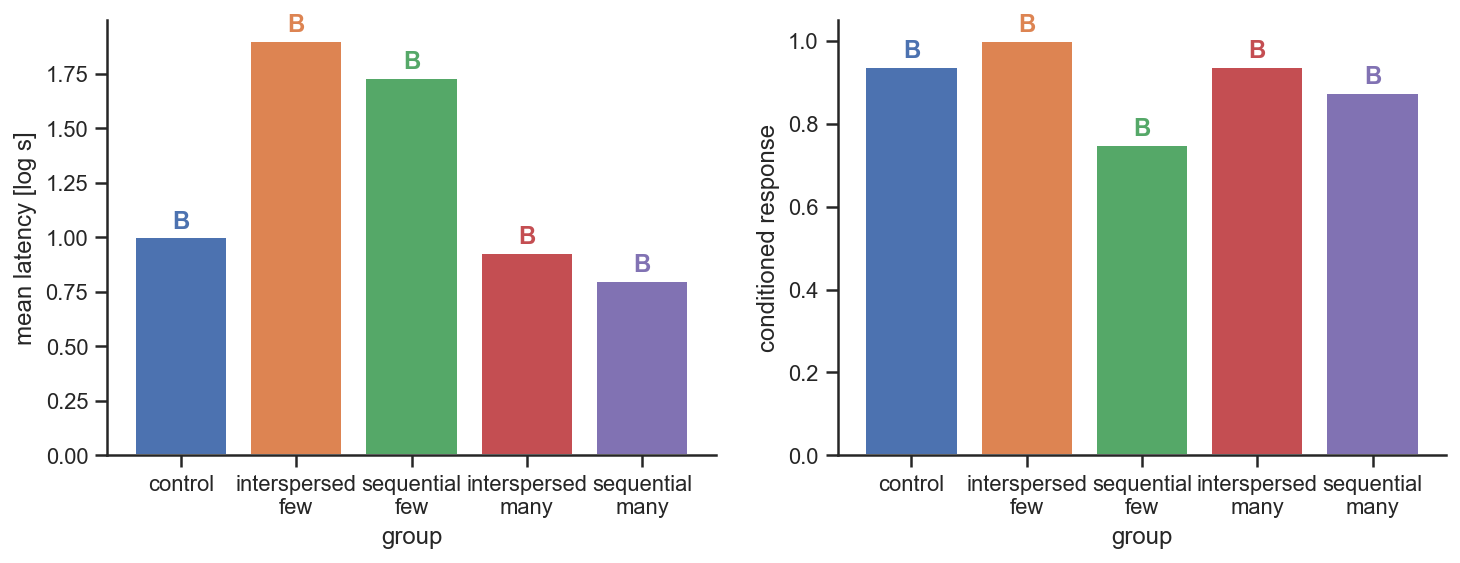

In [6]:
import ccnlab.benchmarks.classical as classical
import ccnlab.evaluation as evaluation
    
for exp in classical.registry('*'):
    display_heading(exp.name, level=2)
    print(classical.repr_spec(exp.spec))
    
    for g, group in exp.stimuli.items():
        for subject in range(1):
            model = RandomModel()
            for i, trial in enumerate(group):
                for t, timestep in enumerate(trial):
                    cs, ctx, us = timestep
                    res = model.act(cs, ctx, us)
                    exp.data[g][i][t]['response'].append(res)

    results = exp.results
    summary = exp.summarize()
    print('correlation:', evaluation.correlation(results, summary))
    display_side_by_side(results, summary)
    exp.plot(show='both')
    plt.show()

In [8]:
len(classical.registry())

30

# Extensions

In [8]:
import ccnlab.benchmarks.classical.core as cc

In [16]:
class TestExperiment(cc.ClassicalConditioningExperiment):
    def __init__(self):
        super().__init__({
            'control': cc.seq(cc.trial('AB+'), repeat=6),
            'special': cc.seq(cc.trial('AB+'), cc.trial('A+'), repeat=6),
        })
        self.results = pd.melt(pd.DataFrame(
            columns=['group', 'trial', 'AB'],
            data=[
                ['control', 1, 0.2],
                ['control', 2, 0.3],
                ['control', 3, 0.4],
                ['control', 4, 0.5],
                ['control', 5, 0.6],
                ['control', 6, 0.7],
                ['special', 1, 0.2],
                ['special', 2, 0.3],
                ['special', 3, 0.4],
                ['special', 4, 0.5],
                ['special', 5, 0.6],
                ['special', 6, 0.7],
            ]
        ), id_vars=['group', 'trial'])
        self.meta = dict(ylabel='hi')
        self.plots = [
            lambda df, ax, **info: cc.plot_lines(df, ax=ax),
        ]

    def summarize(self):
        return pd.melt(self.dataframe(lambda x: {
            'AB': cc.conditioned_response(x['trial'], x['response'], ['A', 'B']),
        }), id_vars=['group', 'trial']).groupby(['group', 'trial', 'variable']).mean().reset_index()

# Implementation

In [8]:
import ccnlab.benchmarks.classical.core as cc

## Syntax tree `self.spec`

In [14]:
# Standard cs_active=(4, 8), us_active=(7, 8)
display(cc.trial('AB+'))

# Control of time
display(cc.trial(('A', 4, 8), ('B', 4, 8), ('+', 7, 8)))

# Control of time + magnitude
display(cc.trial(('A', 4, 8, 0.5), ('B', 4, 8, 0.5), ('+', 7, 8, 0.8)))

# All syntax.
display(cc.seq(
    cc.sample({
        cc.trial('A+'): 8,
        cc.trial('A-'): 2,
    }),
    name='train',
    repeat=1,
))

Trial(cs=(Stimulus(stim='A', start=4, end=8, mag=1), Stimulus(stim='B', start=4, end=8, mag=1)), ctx='K1', us=Stimulus(stim='+', start=7, end=8, mag=1))

Trial(cs=(Stimulus(stim='A', start=4, end=8, mag=1), Stimulus(stim='B', start=4, end=8, mag=1)), ctx='K1', us=Stimulus(stim='+', start=7, end=8, mag=1))

Trial(cs=(), ctx='K1', us=Stimulus(stim='+', start=7, end=8, mag=0.8))

Sequence(children=(Sample(prob={Trial(cs=(Stimulus(stim='A', start=4, end=8, mag=1),), ctx='K1', us=Stimulus(stim='+', start=7, end=8, mag=1)): 8, Trial(cs=(Stimulus(stim='A', start=4, end=8, mag=1),), ctx='K1', us=Stimulus(stim='+', start=7, end=8, mag=0)): 2}),), repeat=1, name='train')

In [15]:
display(cc.build_stimuli(cc.trial('AB+')))
display(cc.build_stimuli(cc.sample({ cc.trial('A'): 1, cc.trial('B'): 1 })))
display(cc.build_stimuli(cc.seq(cc.trial('A'), cc.trial('B'), repeat=3)))
display(cc.build_stimuli(cc.seq(cc.sample({ cc.trial('A'): 1, cc.trial('B'): 1 }), repeat=4)))

([[([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1), ('B', 1)], 'K1', 0),
   ([('A', 1), ('B', 1)], 'K1', 0),
   ([('A', 1), ('B', 1)], 'K1', 0),
   ([('A', 1), ('B', 1)], 'K1', 1)]],
 [None])

([[([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0)]],
 [None])

([[([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], '

([[([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0)]],
 [None, None, None, None])

## Summary statistics `summarize()`

In [18]:
stimuli, phases = cc.build_stimuli(cc.trial('AB+'))
stimuli = stimuli[0]
responses = [0, 0, 1, 0, 0, 1, 1, 1]
display(stimuli)
display(responses)
print('total:', cc.count_responses(stimuli, responses))
print('ctx only:', cc.count_responses(stimuli, responses, during_cs=[]))
print('cs period:', cc.count_responses(stimuli, responses, during_cs=['A', 'B'], during_us=False))
print('cr:', cc.conditioned_response(stimuli, responses, during_cs=['A', 'B']))
print('sr:', cc.suppression_ratio(stimuli, responses, during_cs=['A', 'B']))

[([], 'K1', 0),
 ([], 'K1', 0),
 ([], 'K1', 0),
 ([], 'K1', 0),
 ([('A', 1), ('B', 1)], 'K1', 0),
 ([('A', 1), ('B', 1)], 'K1', 0),
 ([('A', 1), ('B', 1)], 'K1', 0),
 ([('A', 1), ('B', 1)], 'K1', 1)]

[0, 0, 1, 0, 0, 1, 1, 1]

total: 4
ctx only: 1
cs period: 2
cr: 0.6666666666666666
sr: 0.6666666666666666


In [20]:
df = pd.melt(pd.DataFrame(
    columns=['group', 'trial', 'cr'],
    data=[
        [1, 1, 1],
        [1, 2, 2],
        [1, 3, 3],
        [1, 4, 4],
        [1, 5, 5],
        [1, 6, 6],
        [2, 1, 2],
        [2, 2, 4],
        [2, 3, 6],
        [2, 4, 8],
        [2, 5, 10],
        [2, 6, 12],
    ]
), id_vars=['group', 'trial'])

# def trials_to_sessions(
#     df,
#     trials_per_session,
#     keep_first=False,
#     trial_name='trial',
#     session_name='session',
#     value_name='value',
# )

display(df)
cc.trials_to_sessions(df, 3, keep_first=True)

,group,trial,variable,value
0,1,1,cr,1
1,1,2,cr,2
2,1,3,cr,3
3,1,4,cr,4
4,1,5,cr,5
5,1,6,cr,6
6,2,1,cr,2
7,2,2,cr,4
8,2,3,cr,6
9,2,4,cr,8


,group,session,variable,value
0,1,0,cr,1
1,1,1,cr,2
2,1,2,cr,5
3,2,0,cr,2
4,2,1,cr,4
5,2,2,cr,10


## Plotting `plot()`

,group,trial,variable,value
0,control,1,A,0.0
1,control,2,A,0.2
2,control,3,A,0.4
3,control,4,A,0.5
4,control,5,A,0.6
5,testing,1,A,0.0
6,testing,2,A,0.4
7,testing,3,A,0.7
8,testing,4,A,0.8
9,testing,5,A,0.9


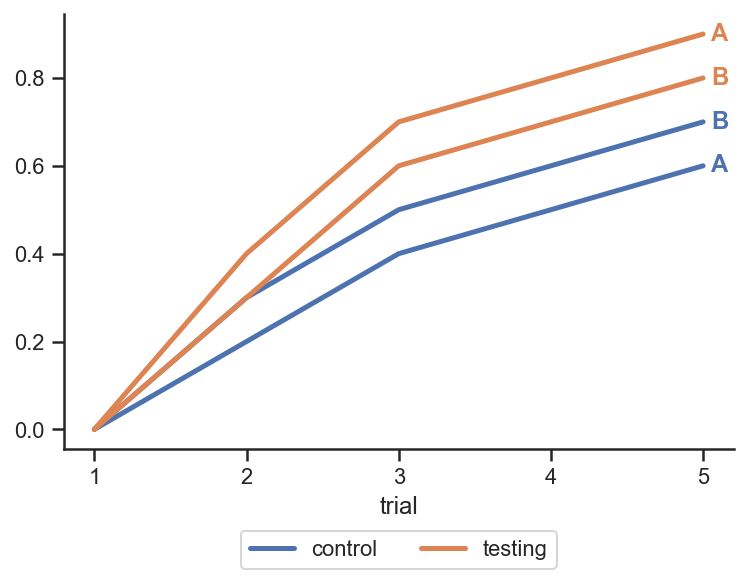

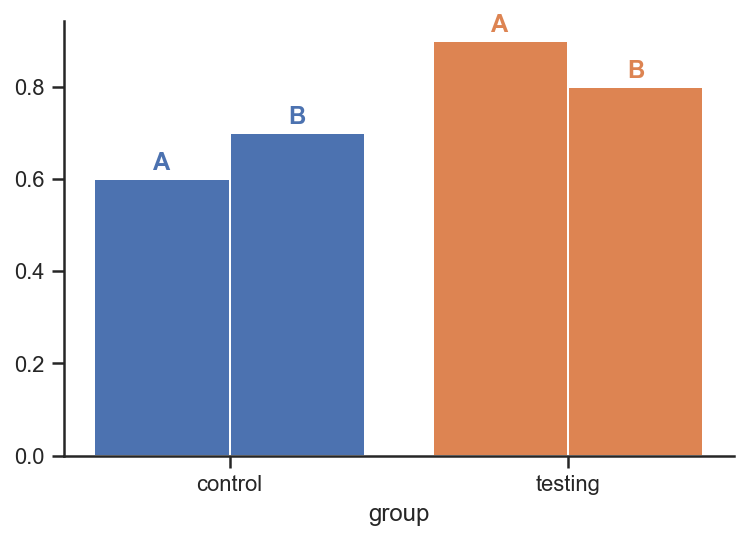

In [9]:
df = pd.melt(pd.DataFrame([
    ['control', 1, 0, 0], ['control', 2, 0.2, 0.3], ['control', 3, 0.4, 0.5], ['control', 4, 0.5, 0.6], ['control', 5, 0.6, 0.7],
    ['testing', 1, 0, 0], ['testing', 2, 0.4, 0.3], ['testing', 3, 0.7, 0.6], ['testing', 4, 0.8, 0.7], ['testing', 5, 0.9, 0.8],
], columns=['group', 'trial', 'A', 'B']), id_vars=['group', 'trial'])

display(df)
cc.plot_lines(df)
cc.plot_bars(df[df['trial'] == 5])


In [23]:
df1 = pd.melt(pd.DataFrame(
    columns=['group', 'trial', 'cr', 'cr2'],
    data=[
        [1, 2, 3, 6],
        [2, 3, 4, 8],
        [3, 4, 5, 10],
    ]
), id_vars=['group', 'trial'])
df2 = pd.melt(pd.DataFrame(
    columns=['group', 'trial', 'cr', 'cr2'],
    data=[
        [1, 2, 3, 7],
        [2, 3, 5, 8],
        [3, 4, 6, 9],
    ]
), id_vars=['group', 'trial'])
display(df1, df2)

from ccnlab.evaluation import correlation
correlation(df1, df2)

,group,trial,variable,value
0,1,2,cr,3
1,2,3,cr,4
2,3,4,cr,5
3,1,2,cr2,6
4,2,3,cr2,8
5,3,4,cr2,10


,group,trial,variable,value
0,1,2,cr,3
1,2,3,cr,5
2,3,4,cr,6
3,1,2,cr2,7
4,2,3,cr2,8
5,3,4,cr2,9


0.9585966633705806

In [ ]:
# X compute cr per trial
# X compare simulated vs experimental stats

# X plotting

# X cr per trial = [group, trial, cr]; group by session?
# X cr per group = [group, cr]; select by phase? select by trial stimuli?

# saving experiments (pickle) and plots (matplotlib)

# QUESTIONS
# session vs trial?
# how to measure CR not UR? Use sum or max over timesteps in trial?
# what is suppression ratio baselines?

# QUESTIONS
# suppression ratio for only aversive stimuli?
# suppression ratio smoothing? edge case of denom 0?

# IDEA: allow for both summary stats input and full experimental data
# IDEA: configurable evaluation function

# QUESTIONS
# aggregating across sessions
# suppression ratio, vs suppression, vs normal cr

# don't implement differences, experiment-level appetitive/aversive, us-level appetitive/aversive, transform all into common framework
# averaging
